# Edge Cases in Expressivity

In this notebook we show the results of the offset prediction experiments on single layer S4D and Mamba models. The models  have been trained on time series of length 200 for at most 100 epochs each. The checkpoints we use here are the `best` with respect to predicting the offset.

Here we provide results for the following experiments in the paper:


1.   Offset Prediction
2.   Consecutive ISI Phase Alignment Test (generalization test)
3.   Double ISI Phase Alignment Test ((generalization test)


This notebook takes ~30 mins to run. ~15 mins to train each model.


## Download S4D and Mamba code

In [1]:
! wget -O s4.py https://raw.githubusercontent.com/state-spaces/s4/refs/heads/main/models/s4/s4.py
! wget -O mamba.py https://raw.githubusercontent.com/johnma2006/mamba-minimal/refs/heads/master/model.py
! sed '27,152d' s4.py > tmp && mv tmp s4.py
! grep -v 'lightning' s4.py > tmp && mv tmp s4.py

--2025-07-06 21:04:27--  https://raw.githubusercontent.com/state-spaces/s4/refs/heads/main/models/s4/s4.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76217 (74K) [text/plain]
Saving to: ‘s4.py’

s4.py               100%[===================>]  74.43K  --.-KB/s    in 0.01s   

2025-07-06 21:04:27 (5.34 MB/s) - ‘s4.py’ saved [76217/76217]

--2025-07-06 21:04:28--  https://raw.githubusercontent.com/johnma2006/mamba-minimal/refs/heads/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12940 (13K) [text/plain]
Saving t

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.auto import tqdm

import csv

import numpy as np
import matplotlib.pyplot as plt
import wandb
from pathlib import Path
from mamba import Mamba, ModelArgs
from s4 import *

## S4D

In [3]:
class S4DLayer(nn.Module):
    def __init__(
        self,
        d_model,
        d_state,
        channels=1,
        activation="gelu",
        dropout=0.0,
        use_residual=True,
        **ssm_kwargs
    ):
        super().__init__()
        self.kernel = SSMKernelDiag(
            d_model=d_model, d_state=d_state, channels=channels, **ssm_kwargs
        )
        self.channel_mixer = nn.Linear(channels * d_model, d_model)
        self.activation = Activation(activation)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.use_residual = use_residual
        self.d_model = d_model
        self.d_state = d_state
        self.channels = channels

    def forward(self, x):
        """
        Args:
            x: shape (b, l, d)

        Returns:
            output: shape (b, l, d)
        """
        self.kernel._setup_step()
        B, L, d = x.shape
        state = self.default_state(B)
        outputs = []
        for t in range(L):
            x_t = x[:, t]  # (b, d)
            y_t, state = self.kernel.step(x_t, state)
            outputs.append(y_t)
        y = torch.concatenate(outputs, dim=1)  # (b, l, d)
        y = self.channel_mixer(y)
        y = self.activation(y)
        y = self.dropout(y)
        if self.use_residual:
            y = y + x
        y = self.norm(y)
        return y

    def default_state(self, batch_size):
        return self.kernel.default_state(batch_size)


class S4D(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model,
        d_state,
        n_layers,
        activation="gelu",
        dropout=0.0,
        use_residual=True,
        **ssm_kwargs
    ):
        super().__init__()
        self.output_proj = nn.Linear(d_model, vocab_size)
        self.embedding = nn.Embedding(vocab_size, d_model)

        self.seq = nn.Sequential(
            *[
                S4DLayer(
                    d_model=d_model,
                    d_state=d_state,
                    activation=activation,
                    dropout=dropout,
                    use_residual=use_residual,
                    **ssm_kwargs
                )
                for _ in range(n_layers)
            ]
        )

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.d_state = d_state
        self.n_layers = n_layers

    def forward(self, x):
        """
        Args:
            x: shape (b, l)

        Returns:
            y: shape (b, l, vocab_size)
        """
        x = self.embedding(x)  # (b, l, d)
        x = self.seq(x)
        x = self.output_proj(x)
        return x

# Offset Prediction

## Helper Code

In [4]:

class AlternatingSignalDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def generate_trace_task(num_seq=1000, n=200, two_peaks=False, holdout_intervals=None):
    holdout_inputs = []
    holdout_targets = []
    inputs = []
    targets = []
    # two_peaks = False
    # np.random.seed(102002)

    for seq_num in range(num_seq):
        signal = []
        length = 0

        # Set on/off lengths and peak distances based on `n`
        if n == 200 or n == 300 or n == 400:
            if not two_peaks:
                off_length = np.random.randint(20, 40)
                on_length = 20
            else:
                # off_length = np.random.randint(20, 70)
                off_length = 20
                peak_distance = 50
                on_length = 10

        elif n == 600:
            if not two_peaks:
                off_length = np.random.randint(60, 120)
                on_length = 60

            else:
                off_length = 200
                peak_distance = 200
                on_length = 30

        elif n == 1000:
            if not two_peaks:
                off_length = np.random.randint(100, 200)
                on_length = 100

            else:
                off_length = 400
                peak_distance = 400

                on_length = 50
        else:
            raise ValueError("Unsupported value of n. Choose 200, 600, or 1000.")

        # Generate the signal with one or two peaks based on `two_peaks`
        signal.extend([0] * off_length)
        signal.extend([1] * on_length)

        if two_peaks:
            # Add the specified distance between peaks, followed by the second peak
            signal.extend([0] * peak_distance)
            signal.extend([1] * on_length)

        # Fill with 0s until the signal length matches `n`
        signal.extend([0] * (n - len(signal)))

        # Trim in case signal exceeds `n` (shouldn’t normally happen with the fill above)
        # print('length of signal: ', len(signal))
        signal = signal[:n]

        # Convert signal to tensor format
        ts = torch.tensor(signal, dtype=torch.long)

        # Create input and target sequences
        input_seq = ts
        target_seq = torch.cat((torch.tensor([0]*1, dtype=torch.long), ts[:-10]), dim=0)
        # print('input shape: ', input_seq.shape)

        # Check if the current sequence is part of the holdout intervals
        if holdout_intervals and seq_num in holdout_intervals:
            holdout_inputs.append(input_seq)
            holdout_targets.append(target_seq)
        else:
            inputs.append(input_seq)
            targets.append(target_seq)

    # print(f'\nNUMBER OF INPUTS {torch.stack(holdout_inputs).shape}\n')
    # print(f'\nShape of inputs: {torch.stack(inputs).shape}')
    return torch.stack(targets), torch.stack(inputs), torch.stack(holdout_targets), torch.stack(holdout_inputs)


def generate_inter_trial_interval(num_seq=1000, n=200, iti=(20, 40), isi=10, holdout_intervals=None):
    '''
    Generate data to train S4D model.
    Data is of the form: initially off for (20-40) time steps,
    then on for 10 time steps, and repeats.
    The length of the signals should be 200 time steps.
    '''
    holdout_inputs = []
    holdout_targets = []
    inputs = []
    targets = []

    for seq_num in range(num_seq):
        signal = []
        length = 0

        while length < n:
            # off_length = np.random.randint(20, 40)
            off_length = np.random.randint(iti[0], iti[1])
            # off_length = np.random.randint(2, 8)

            # on_length = 10
            on_length = isi
            # on_length = 2
            signal.extend([0] * off_length)
            signal.extend([1] * on_length)
            length += off_length + on_length

        signal = signal[:n]
        ts = torch.tensor(signal, dtype=torch.long)

        # Create input and target sequences
        input_seq = ts
        target_seq = torch.cat((ts[1:], torch.tensor([0], dtype=torch.long)), dim=0)

        # Check if the current sequence is part of the holdout intervals
        if holdout_intervals and seq_num in holdout_intervals:
            holdout_inputs.append(input_seq)
            holdout_targets.append(target_seq)
        else:
            inputs.append(input_seq)
            targets.append(target_seq)

    return torch.stack(inputs), torch.stack(targets), torch.stack(holdout_inputs), torch.stack(holdout_targets)

def get_offset_indices(signal):
    """
    Find all indices where ISI turns off (transitions from 1 to 0) in a signal.

    Args:
        signal: A torch.Tensor of shape [200] or similar 1D tensor

    Returns:
        List of integers representing indices where the signal transitions from 1 to 0
    """
    # Ensure we're working with a 1D tensor with proper values
    if torch.is_tensor(signal):
        # If tensor has extra dimensions, flatten it
        if signal.dim() > 1:
            signal = signal.flatten()

        # Convert to numpy for easier processing
        signal_np = signal.detach().cpu().numpy()
    else:
        # If it's already a numpy array or list
        signal_np = np.array(signal)

    # Find transitions from 1 to 0
    # Using numpy operations for efficiency
    transitions = np.diff(signal_np.astype(int))
    # A transition from 1 to 0 will have a difference of -1
    offset_indices = np.where(transitions == -1)[0] + 1  # +1 because diff gives index before transition

    return offset_indices.tolist()


def get_offset_indices_batched(signals):
    """
    Find all indices where ISI turns off (transitions from 1 to 0) for a batch of signals.

    Args:
        signals: A torch.Tensor of shape [batch_size, sequence_length], e.g., [8, 200]

    Returns:
        List of lists, where each inner list contains the offset indices for one signal in the batch
    """
    if not torch.is_tensor(signals):
        signals = torch.tensor(signals)

    # Ensure the tensor is on CPU for numpy conversion
    if signals.device.type != 'cpu':
        signals = signals.detach().cpu()

    # Initialize list to store offsets for each signal in the batch
    batch_offsets = []

    # Process each signal in the batch
    for i in range(signals.shape[0]):
        # Extract single signal
        signal = signals[i]

        # Convert to numpy
        signal_np = signal.numpy()

        # Find transitions from 1 to 0 using numpy diff
        transitions = np.diff(signal_np.astype(int))

        # A transition from 1 to 0 will have a difference of -1
        offset_indices = np.where(transitions == -1)[0] + 1  # +1 because diff gives index before transition

        # Store the offsets for this signal
        batch_offsets.append(offset_indices.tolist())

    return batch_offsets


def get_flat_batch_indices(batch_tensor):
    """
    Get flat (batch_idx, seq_idx) pairs for all ISI offset points.

    Args:
        batch_tensor: A torch.Tensor of shape [batch_size, sequence_length]

    Returns:
        Two numpy arrays:
        - batch_indices: array of batch indices
        - seq_indices: array of sequence indices where ISI turns off
    """
    # Get lists of offset indices for each sequence in the batch
    batch_offsets = get_offset_indices_batched(batch_tensor)

    # Prepare flat arrays
    batch_indices = []
    seq_indices = []

    # Collect all (batch_idx, seq_idx) pairs
    for batch_idx, offsets in enumerate(batch_offsets):
        for seq_idx in offsets:
            batch_indices.append(batch_idx)
            seq_indices.append(seq_idx)

    return np.array(batch_indices), np.array(seq_indices)


def check_batch_match_at_offset(binary_output, targets, match_threshold=0.5):
    """
    Checks if at least half of the batch from binary output matches the target at offset indices.

    Args:
        binary_output: Tensor of shape [batch_size, sequence_length] with binary values (0 or 1)
        targets: Tensor of shape [batch_size, sequence_length] or [batch_size, sequence_length, 1]
        match_threshold: Minimum fraction of matches required (default: 0.5 means at least 50%)

    Returns:
        tuple: (match_ratio, match_result, match_details)
            - match_ratio: Fraction of sequences with matching offsets
            - match_result: Boolean indicating if match_ratio >= match_threshold
            - match_details: Dictionary with detailed information about matches
    """
    # Get batched offset indices
    batch_offsets = get_offset_indices_batched(targets.squeeze())


    # Make sure targets has same shape as binary_output
    if targets.dim() > binary_output.dim():
        targets = targets.squeeze(-1)

    # Move tensors to CPU for processing
    if binary_output.device.type != 'cpu':
        binary_output = binary_output.detach().cpu()
    if targets.device.type != 'cpu':
        targets = targets.detach().cpu()

    # Initialize counters
    batch_size = binary_output.shape[0]
    sequences_with_matches = 0
    total_offsets = 0
    total_matches = 0
    match_details = {}

    # Check each sequence in the batch
    for batch_idx, offsets in enumerate(batch_offsets):
        if not offsets:  # Skip if no offsets found
            match_details[f"sequence_{batch_idx}"] = {
                "offsets": 0,
                "matches": 0,
                "match_ratio": 0,
                "status": "no_offsets"
            }
            continue

        # Count matches for this sequence
        sequence_matches = 0
        sequence_details = []

        for offset_idx in offsets:
            # The actual offset where ISI turns off
            offset = offset_idx

            # Check if value at offset matches in target
            # We expect 0 at offset since that's where ISI turns off
            # But we check preceding value to see if target also turns off at same point
            if offset > 0 and offset < binary_output.shape[1]:
                # Get the value before the transition (should be 1)
                prev_binary = binary_output[batch_idx, offset-1].item()
                prev_target = targets[batch_idx, offset-1].item()

                # Get the value at the transition (should be 0)
                curr_binary = binary_output[batch_idx, offset].item()
                curr_target = targets[batch_idx, offset].item()

                # Check if pattern matches: 1→0 transition in both binary_output and target
                transition_match = (prev_binary > 0.5 and prev_target > 0.5 and
                                    curr_binary < 0.5 and curr_target < 0.5)

                if transition_match:
                    sequence_matches += 1

                sequence_details.append({
                    "offset": offset,
                    "binary_before": prev_binary,
                    "target_before": prev_target,
                    "binary_at": curr_binary,
                    "target_at": curr_target,
                    "match": transition_match
                })

        # Calculate match ratio for this sequence
        seq_match_ratio = sequence_matches / len(offsets) if offsets else 0
        sequence_has_match = seq_match_ratio >= match_threshold

        if sequence_has_match:
            sequences_with_matches += 1

        # Store sequence details
        match_details[f"sequence_{batch_idx}"] = {
            "offsets": len(offsets),
            "matches": sequence_matches,
            "match_ratio": seq_match_ratio,
            "status": "match" if sequence_has_match else "no_match",
            "details": sequence_details
        }

        # Update totals
        total_offsets = len(offsets)
        total_matches += sequence_matches

    # Calculate overall match ratio
    batch_match_ratio = sequences_with_matches / batch_size if batch_size > 0 else 0
    overall_match_ratio = total_matches / total_offsets if total_offsets > 0 else 0

    # Add summary to match details
    match_details["summary"] = {
        "batch_size": batch_size,
        "sequences_with_matches": sequences_with_matches,
        "batch_match_ratio": batch_match_ratio,
        "total_offsets": total_offsets,
        "total_matches": total_matches,
        "overall_match_ratio": overall_match_ratio,
        "threshold_met": batch_match_ratio >= match_threshold
    }

    return batch_match_ratio, batch_match_ratio >= match_threshold, match_details


# Split train data into train and validation sets
def split_train_val_og(train_inputs, train_targets, val_split=0.1):
    dataset_size = len(train_inputs)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))

    np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_inputs_split = train_inputs[train_indices]
    train_targets_split = train_targets[train_indices]

    val_inputs_split = train_inputs[val_indices]
    val_targets_split = train_targets[val_indices]

    return train_inputs_split, train_targets_split, val_inputs_split, val_targets_split



# split dataset into train and validation sets
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val



def visualize_signals(input_signal, target_signal):

    fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(8, 8))

    # ax = axes[0]
    # ax.plot(input_signal.numpy(), 'r', label=' ITI ')
    # ax.plot(target_signal.numpy(), 'b', label=' ISI ')

    ax.plot(input_signal.numpy(), 'r', label='Input')
    ax.plot(target_signal.numpy(), 'b', label='Target')

    # labelLines(ax.get_lines(), zorder=5.5, color='r')


    plt.legend()
    plt.title('Input Signal')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
    # plt.savefig('./test_out.png')


def train(model, dataloader, device, optimizer, criterion, model_name, grad_clip,
          mse_log, loss_log):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_inputs, batch_targets in dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()

        if model_name == 'Transformer':
            seq_len = batch_inputs.size(1)
            src_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(device)
            predictions = model(batch_inputs, src_mask=src_mask)
        else:
            predictions = model(batch_inputs)

        num_classes = predictions.shape[-1]
        loss = criterion(predictions.view(-1, num_classes), batch_targets.view(-1))
        loss.backward()

        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()
        loss_log.append(loss.item())

        # Compute MSE for class 1 probability (for binary classification)
        probs_class1 = torch.softmax(predictions, dim=-1)[..., 1]
        mse = F.mse_loss(probs_class1, batch_targets.float()).item()
        mse_log.append(mse)

        # Accuracy computation
        predicted_classes = predictions.argmax(dim=-1)
        total_correct += (predicted_classes == batch_targets).sum().item()
        total_samples += batch_targets.numel()

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return average_loss, accuracy


def eval(model, valloader, device, criterion, epoch, model_name, clip_grad):
    model.eval()
    eval_loss = 0
    total = 0
    total_batches = len(valloader)

    with torch.no_grad():
        for batch_ind, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)

            if model_name == 'Transformer':
                src_mask = nn.Transformer.generate_square_subsequent_mask(inputs.size(1)).to(device)
                outputs = model(inputs, src_mask=src_mask)
            else:
                outputs = model(inputs)

            d_output = outputs.shape[-1]
            loss = criterion(outputs.view(-1, d_output), targets.view(-1))
            mse = F.mse_loss(torch.softmax(outputs, dim=-1)[..., 1], targets).item()

            eval_loss += loss.item()
            total += inputs.size(0)

    avg_loss = eval_loss / total_batches
    # print(f"Epoch {epoch} - Eval Loss: {avg_loss:.4f}")


def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # print('all parameters: ', all_parameters)

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler



def see_all():
    '''
    viz all train and test data in one image
    '''

    test_ckpt = torch.load('./datasets/trace/test.pth')


    # print(test_ckpt.dataset.__len__())
    test_inputs = test_ckpt.dataset.inputs
    test_targets = test_ckpt.dataset.targets
    # Number of subplots (assuming you want one plot for each input-target pair)
    num_plots = len(test_inputs) + len(test_targets)

    # Determine grid size (e.g., square or close to square)
    grid_size = int(np.ceil(np.sqrt(num_plots)))

    # Create subplots grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))  # Adjust the figsize as needed
    axes = axes.flatten()  # Flatten in case grid_size doesn't match perfectly

    # Plot each input in a separate subplot
    for idx, inputs in enumerate(test_inputs):
        axes[idx].plot(inputs)
        axes[idx].set_title(f'Input {idx+1}')

    # Plot each target in a separate subplot, continuing from where inputs left off
    for idx, targets in enumerate(test_targets):
        axes[len(test_inputs) + idx].plot(targets)
        axes[len(test_inputs) + idx].set_title(f'Target {idx+1}')

    # Hide any remaining empty subplots if number of plots isn't a perfect square
    for ax in axes[num_plots:]:
        ax.axis('off')

    plt.tight_layout()  # Ensure plots are neatly organized
    plt.show()


def model_params(seed, model_checkpoint, model_type, hidden, output_file):

    num_layers = 1
    input_size = 1
    hidden_size = int(hidden)

    # Print the model details (optional)
    print(model_type, input_size, hidden_size, num_layers)

    # Initialize the model (assuming get_model is defined elsewhere)
    model = get_model(model_type, input_size, hidden_size, num_layers)

    # Load model from checkpoint
    checkpoint = torch.load(model_checkpoint, weights_only='False')

    # Check if the checkpoint contains 'model_state_dict'
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total number of parameters: {total_params}")
    else:
        print("Checkpoint does not contain 'model_state_dict'.")
        total_params = 'N/A'  # Default value if state_dict is not found

    # Prepare data to write into the CSV file
    data = [model_type, input_size, hidden_size, num_layers, total_params, seed]

    # Write the parameters into the CSV file
    with open(output_file, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Check if file is empty to write the header
        file.seek(0, 2)  # Move the pointer to the end of the file
        if file.tell() == 0:
            writer.writerow(['Model Type', 'Input Size', 'Hidden Size', 'Num Layers', 'Total Params', 'Seed'])

        # Write the model details
        writer.writerow(data)

    print(f"Model parameters saved to {output_file}.")

In [5]:
# model_eval.py

"""
Model Evaluation Module
Easy-to-import module for running model evaluations in Google Colab
"""

from pathlib import Path
import re
import torch
from torch import nn
import numpy as np
import os
from typing import Dict, Tuple, Optional, Union, List
import ast


def get_model(model_name, vocab_size, hidden_size, state_size, num_layers):
    """Initialize and return a model based on the model name."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if model_name == 'S4D':
        if S4D is None:
            raise ImportError("S4D model class not available")
        # model = S4D(
        #     d_model=hidden_size,
        #     n_layers=num_layers,
        #     n_vocab=vocab_size,
        #     dropout=0,
        #     d_state=state_size,
        #     embed=True
        # )
        model = S4D(
            vocab_size=vocab_size,
            d_model=hidden_size,
            d_state=state_size,
            n_layers=num_layers,
            dt_min=0.001,
            dt_max=0.1,
            init='legs'
        )
    elif model_name == 'MAMBA':
        if Mamba is None:
            raise ImportError("Mamba model class not available")
        d_model = hidden_size
        d_state = state_size
        n_layers = num_layers
        model_args = ModelArgs(d_model, n_layers, vocab_size, d_state, pad_vocab_size_multiple=1)
        print(model_args)
        model = Mamba(model_args)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    model = model.to(device)
    return model

def load_test_data(ts_length, data_path):
    """Load test dataset for evaluation"""
    print(f"Loading test data from: {data_path}")
    testset_path = Path(data_path)
    print(f"Loading test data from: {testset_path}")

    if not testset_path.exists():
        raise FileNotFoundError(f"Test data file not found: {testset_path}")

    test_data = torch.load(testset_path, weights_only=False)
    print(f"Test data loaded successfully")
    return test_data

def setup_environment() -> str:
    """Set up environment and return device."""
    import warnings
    warnings.filterwarnings('ignore')

    # Set random seed for reproducibility
    np.random.seed(192390)

    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    return device

def extract_model_info(file_path: str) -> Optional[Dict[str, Union[str, int, float, Path]]]:
    """Extract model information from checkpoint file path."""
    # Updated pattern to handle scientific notation in learning rates (e.g., 1e-05)
    pattern = r'(\w+)_([\d\.e\-]+)_([\d]+)_64_([\d]+)_ckpt_([\d]+)_([\d]+)\.pth'

    # Convert to Path object if it's a string
    path_obj = Path(file_path)

    # Check if file exists
    if not path_obj.exists():
        print(f"Checkpoint file does not exist: {file_path}")
        return None

    match = re.search(pattern, path_obj.name)

    if match:
        model_info = {
            'model': match.group(1),
            'learning_rate': float(match.group(2)),
            'hidden_size': int(match.group(3)),
            'epochs': int(match.group(4)),
            'checkpoint_id': int(match.group(5)),
            'date': match.group(6),
            'matching_file': file_path
        }
        print(f"Extracted model info: {model_info['model']}, lr={model_info['learning_rate']}, "
              f"hidden_size={model_info['hidden_size']}, checkpoint_id={model_info['checkpoint_id']}, "
              f"date={model_info['date']}")
        return model_info
    else:
        # Try the old pattern as a fallback
        old_pattern = r'(\w+)_([\d]+)_64_([\d]+)_ckpt_([\d]+)'
        match = re.search(old_pattern, path_obj.name)

        if match:
            model_info = {
                'model': match.group(1),
                'hidden_size': int(match.group(2)),
                'epochs': int(match.group(3)),
                'checkpoint_id': int(match.group(4)),
                'matching_file': file_path
            }
            print(f"Extracted model info (old format): {model_info['model']}, "
                  f"hidden_size={model_info['hidden_size']}, checkpoint_id={model_info['checkpoint_id']}")
            return model_info
        else:
            print(f"Could not extract model info from {file_path} - file name doesn't match expected pattern")
            return None

def generate_data(seq_len: int, phase: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate data based on sequence length and phase alignment."""
    print(f"Generating data with seq_len={seq_len}, phase={phase}")

    # Generate random holdout intervals
    np.random.seed(192390)
    holdout_intervals = np.random.randint(0, 99, size=10).tolist()
    phase_tuple = ast.literal_eval(phase)

    try:
        if seq_len == 200:
            if phase_tuple[0]:
                train_inputs, train_targets, test_inputs, test_targets = generate_trace_task(1000, 200, phase_tuple[1], holdout_intervals=holdout_intervals)
            else:
                train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(1000, 200, holdout_intervals=holdout_intervals)
        elif seq_len == 300:
          if phase_tuple[0]:
              train_inputs, train_targets, test_inputs, test_targets = generate_trace_task(1000, 300, phase_tuple[1], holdout_intervals=holdout_intervals)
          else:
              train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(1000, 300, holdout_intervals=holdout_intervals)
        elif seq_len == 400:
          if phase_tuple[0]:
              train_inputs, train_targets, test_inputs, test_targets = generate_trace_task(1000, 400, phase_tuple[1], holdout_intervals=holdout_intervals)
          else:
              train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(1000, 400, holdout_intervals=holdout_intervals)
        elif seq_len == 600:
            if phase_tuple[0]:
                train_inputs, train_targets, test_inputs, test_targets = generate_trace_task(1000, 600, phase_tuple[1], holdout_intervals=holdout_intervals)
            else:
                train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(num_seq=1000, n=600, iti=(60, 120), isi=30, holdout_intervals=holdout_intervals)
        elif seq_len == 1000:
            if phase_tuple[0]:
                train_inputs, train_targets, test_inputs, test_targets = generate_trace_task(1000, 1000, phase_tuple[1], holdout_intervals=holdout_intervals)
            else:
                train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(num_seq=1000, n=1000, iti=(100, 120), isi=50, holdout_intervals=holdout_intervals)
        else:
            raise ValueError(f"Unsupported sequence length: {seq_len}")

        # print(f'train inputs {train_inputs.shape} {train_targets.shape}')
        # print(f'test inputs {test_inputs.shape} {test_targets.shape}')
        return train_inputs, train_targets, test_inputs, test_targets
    except Exception as e:
        print(f"Error generating data: {e}")
        raise

def evaluate_model(
    model_info: Dict[str, Union[str, int, float, Path]],
    test_inputs: torch.Tensor,
    device: str,
    current_seed: str
) -> Optional[torch.Tensor]:
    """Evaluate a model and return its outputs."""
    model_name = model_info['model']
    file_path = model_info['matching_file']
    hidden_size = model_info['hidden_size']

    print(f"Evaluating model {model_name} (hidden_size={hidden_size}) from {file_path}")

    try:
        # Try to load the checkpoint
        try:
            checkpoint = torch.load(file_path, map_location=device)
            print(f"Successfully loaded checkpoint")
        except Exception as e:
            print(f"Failed to load checkpoint {file_path}: {e}")
            return None

        # Try to initialize the model
        try:
            model = get_model(model_name, 2, hidden_size, 64, 1).to(device)
            print(f"Successfully initialized model")
        except Exception as e:
            print(f"Failed to initialize model {model_name}: {e}")
            return None

        # Try to load the state dict
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Successfully loaded state dict")
        except KeyError:
            print("Checkpoint does not contain 'model_state_dict' key")
            if 'state_dict' in checkpoint:
                print("Trying 'state_dict' key instead")
                try:
                    model.load_state_dict(checkpoint['state_dict'])
                    print("Successfully loaded state dict using 'state_dict' key")
                except Exception as e:
                    print(f"Failed to load alternative state dict: {e}")
                    return None
            else:
                print("No usable state dict found in checkpoint")
                return None
        except Exception as e:
            print(f"Failed to load state dict: {e}")
            return None

        # print('-----------------')
        # if model_name == "MAMBA":
        #     print(model)
        #     for name, param in model.named_parameters():
        #         if 'A_log' in name:
        #             print(f"{name}: {param.shape}")
        #             print(param)
        # print('-----------------')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            try:
                outputs = torch.softmax(model(test_inputs), dim=-1)[..., 1].cpu().detach().squeeze()
                print(f"Successfully evaluated model, output shape: {outputs.shape}")
                return outputs
            except Exception as e:
                print(f"Error during model inference: {e}")
                return None
    except Exception as e:
        print(f"Unexpected error evaluating model {model_name}: {e}")
        return None

def run_evaluation(
    checkpoint_paths: List[str],
    seq_len: int = 200,
    phase: str = '(True, False)',
    sample_idx: int = 3
) -> Dict:
    """
    Main evaluation function that can be easily imported and run.

    Args:
        checkpoint_paths: List of checkpoint file paths. If None, uses defaults.
        seq_len: Sequence length for data generation
        phase: Phase configuration as string
        sample_idx: Sample index (currently unused but kept for compatibility)

    Returns:
        Dictionary containing all results and data for plotting
    """

    # Determine phase type for logging
    if phase == str((True, False)):
        type_phase = 'double'
    elif phase == str((True, True)):
        type_phase = 'conset'
    elif phase == str((False, False)):
        type_phase = 'offset'
    else:
        type_phase = 'None'

    # Log the configuration
    print(f"Configuration: seq_len={seq_len}, phase={phase}, sample_idx={sample_idx}")
    print(f"Number of checkpoint paths: {len(checkpoint_paths)}")

    # Setup
    device = setup_environment()

    # Generate data
    train_inputs, train_targets, test_inputs, test_targets = generate_data(seq_len, phase)

    # Split data
    try:
        train_inputs_split, train_targets_split, val_inputs_split, val_targets_split = split_train_val_og(
            train_inputs, train_targets, val_split=0.1
        )
    except Exception as e:
        print(f"Error splitting data: {e}")
        return None

    # Move test data to device
    test_inputs = test_inputs.to(device)
    test_targets = test_targets.to(device)

    # Create dictionaries to store outputs and model-to-seed mapping
    all_outputs_dict = {}
    model_to_seed_map = {}

    # Process each checkpoint file
    for checkpoint_path in checkpoint_paths:
        print(f"Processing checkpoint: {checkpoint_path}")

        # Skip if file doesn't exist
        if not Path(checkpoint_path).exists():
            print(f"Checkpoint file does not exist: {checkpoint_path}")
            continue

        # Extract model info
        model_info = extract_model_info(checkpoint_path) # apple
        if model_info is None:
            continue

        # Extract seed from the checkpoint path
        seed_match = re.search(r'_ckpt_(\d+)_', checkpoint_path)
        current_seed = seed_match.group(1) if seed_match else "unknown"

        # Evaluate model
        outputs = evaluate_model(model_info, test_inputs, device, current_seed)

        # Create a formatted key for the outputs dictionary that includes learning rate
        if 'learning_rate' in model_info:
            model_name = f"{model_info['model']}_{model_info['learning_rate']}_{model_info['checkpoint_id']}"
        else:
            model_name = f"{model_info['model']}_{model_info['checkpoint_id']}"

        if outputs is not None:
            all_outputs_dict[model_name] = outputs
            model_to_seed_map[model_name] = current_seed

    # Process results
    if all_outputs_dict:
        results_data = []

        for k, v in all_outputs_dict.items():
            binary_output = (v.to(device) >= 0.5).float()

            # Check if at least half of the batch matches at the offset positions
            match_ratio, threshold_met, match_details = check_batch_match_at_offset(
                binary_output,
                test_targets,
                match_threshold=0.5  # At least 50% need to match
            )

            # Get flat batch indices for reference
            batch_idx, seq_idx = get_flat_batch_indices(binary_output)

            # Print the high-level results
            print('='*50)
            print(f'Model: {k}')
            print(f"sequence length: {seq_len}")
            print(f"Match ratio: {match_ratio:.2f}")
            print(f"Threshold met: {threshold_met}")
            print(f"Sequences with matches: {match_details['summary']['sequences_with_matches']} out of {match_details['summary']['batch_size']}")
            print(f"Total matching offsets: {match_details['summary']['total_matches']} out of {match_details['summary']['total_offsets']}")
            print('\n')

            # Store data for plotting
            results_data.append({
                'model_name': k,
                'original_output': v.cpu().detach(),
                'binary_output': binary_output.cpu().detach(),
                'targets': test_targets.cpu().detach(),
                'match_ratio': match_ratio,
                'threshold_met': threshold_met,
                'match_details': match_details
            })

        return {
            'results_data': results_data,
            'all_outputs_dict': all_outputs_dict,
            'seq_len': seq_len,
            'type_phase': type_phase,
            'test_targets': test_targets.cpu().detach(),
            'model_to_seed_map': model_to_seed_map,
            'train_data': {
                'train_inputs': train_inputs,
                'train_targets': train_targets,
                'train_inputs_split': train_inputs_split,
                'train_targets_split': train_targets_split,
                'val_inputs_split': val_inputs_split,
                'val_targets_split': val_targets_split
            }
        }
    else:
        print("No models were successfully evaluated.")
        return None

# Convenience functions for common use cases
def evaluate_single_model(checkpoint_path: str, seq_len: int = 200, phase: str = '(True, False)'):
    """Evaluate a single model."""
    return run_evaluation([checkpoint_path], seq_len, phase)

def evaluate_default_models(seq_len: int = 200, phase: str = '(True, False)'):
    """Evaluate the default MAMBA and S4D models."""
    return run_evaluation(None, seq_len, phase)

def evaluate_custom_models(checkpoint_paths: List[str], seq_len: int = 200, phase: str = '(True, False)'):
    """Evaluate custom list of models."""
    return run_evaluation(checkpoint_paths, seq_len, phase)

# For backward compatibility
def main(checkpoint_path, seq_len, phase, sample_idx):
    """Legacy main function - redirects to run_evaluation."""
    return run_evaluation([checkpoint_path], seq_len, phase, sample_idx)

In [6]:
# trainer.py

import torch
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import os
from pathlib import Path
import datetime
import json
import matplotlib.pyplot as plt


print(os.getcwd())


def trainer(model_name, hidden_s, state_size, memory_size, epochs_length, seed, ckpt_dir, ts_length, lr, clip_grad=None):

    trainset_path = Path(f'datasets/train_{ts_length}_colab.pth')
    testset_path = Path(f'datasets/test_{ts_length}_colab.pth')
    valset_path = Path(f'datasets/val_{ts_length}_colab.pth')
    datasets = [trainset_path, testset_path, valset_path]
    pbar = tqdm(enumerate(datasets))


    # params
    batch_size = 128
    num_workers = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    epochs = epochs_length

    hidden_size = hidden_s
    state_size = state_size

    d_output = 1
    vocab_size = 2
    output_size = 1
    num_layers = 1
    batch_first = True
    dropout = 0
    prenorm = False

    for _, dataset in pbar:
        np.random.seed(seed)
        print(f'\nMaking a new set of Train, Test and Validation data.')
        hld_ot_int = np.random.randint(0, 99, size=200).tolist()

        if ts_length == 200:
            train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(num_seq=1000, n=200, iti=(20, 40), isi=10, holdout_intervals=hld_ot_int)
        if ts_length == 600:
            train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(num_seq=1000, n=600, iti=(60, 120), isi=30 ,holdout_intervals=hld_ot_int)
        if ts_length == 1000:
            train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(num_seq=1000, n=1000, iti=(100, 200), isi=50 ,holdout_intervals=hld_ot_int)

        train_inputs_split, train_targets_split, val_inputs_split, val_targets_split = split_train_val_og(train_inputs, train_targets, val_split=0.1)

        # Save tensors to a file
        torch.save({'inputs': test_inputs, 'targets': test_targets}, Path(f'datasets/test_{ts_length}.pth'))

        train_set = AlternatingSignalDataset(train_inputs_split, train_targets_split)
        val_set = AlternatingSignalDataset(val_inputs_split, val_targets_split)
        test_set = AlternatingSignalDataset(test_inputs, test_targets)
        # load datasets
        trainset, _ = split_train_val(train_set, val_split=0.2)
        _, valset = split_train_val(val_set, val_split=0.1)
        testset, _ = split_train_val(test_set, val_split=0)

        torch.save(trainset, trainset_path)
        torch.save(valset, valset_path)
        torch.save(testset, testset_path)

        print('\nDatasets created!')

        # Dataloaders
        trainloader = DataLoader(
            trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        valloader = DataLoader(
            valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        testloader = DataLoader(
            testset, batch_size=2, shuffle=False, num_workers=num_workers)
        pbar.set_description('Datasets loaded (%d/%d)' % (3,3))

    # save the model params into a file
    with open(f'model_params_experiments_{ts_length}.json', '+a') as file:
        mode_info = {
            'model_name' : model_name +f'_experiments_{ts_length}' ,
            'seed' : seed,
            'hidden_size' : hidden_size,
            'learning_rate' : lr,
            'state/memory_size' : state_size,
            'num_layers' : num_layers,
            'dropout' : dropout,
            'prenorm' : prenorm,
            'batch_size' : batch_size,
            'training_timestamp' : str(datetime.datetime.now()),
            'epochs' : epochs,
            'ts_shape' : trainset.dataset.inputs.shape
        }

        json.dump(mode_info, file, indent=4)

    model = get_model(model_name, vocab_size, hidden_size, state_size, num_layers)


    if model_name == 'S4D':
        criterion = torch.nn.CrossEntropyLoss()
        optimizer, _ = setup_optimizer(model, lr=lr, weight_decay=0.01, epochs=epochs)

    else:
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)


    model = model.to(device)
    if device == 'cuda':
        cudnn.benchmark = True

    all_mse_list = []
    all_loss_list = []

    print(f'\ntraining {model_name}-{seed}')
    pbar = tqdm(range(epochs), desc='Epoch 0')

    for epoch in pbar:
        current_date = datetime.date.today().strftime('%Y%m%d')

        average_loss, accuracy = train(
            model=model,
            dataloader=trainloader,
            device=device,
            optimizer=optimizer,
            criterion=criterion,
            model_name=model_name,
            grad_clip=clip_grad,
            mse_log=all_mse_list,
            loss_log=all_loss_list
        )

        # Update tqdm with epoch and loss
        pbar.set_description(f"Epoch {epoch}")
        pbar.set_postfix(loss=f"{average_loss:.4f}")

        # Save checkpoint
        ckpt_path = f'./{ckpt_dir}/{model_name}/'
        os.makedirs(ckpt_path, exist_ok=True)
        checkpoint_path = f'{ckpt_path}{model_name}_{lr}_{hidden_size}_{state_size}_{epochs}_ckpt_{seed}_{current_date}.pth'

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(all_mse_list, marker='o')
    axs[0].set_title("MSE over All Batches")
    axs[0].set_xlabel("Batch Index")
    axs[0].set_ylabel("MSE")
    axs[0].grid(True)

    axs[1].plot(all_loss_list, marker='x', color='orange')
    axs[1].set_title("Loss over All Batches")
    axs[1].set_xlabel("Batch Index")
    axs[1].set_ylabel("Loss")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f'\nfinished training {model_name}-{seed}')

/content


In [7]:
# plotters.py

import matplotlib.pyplot as plt
import numpy as np
import torch
from typing import Optional, Union
import os

def plot_signals_with_offsets(
    original_output: torch.Tensor,
    binary_output: torch.Tensor,
    targets: torch.Tensor,
    model_name: str,
    num_samples: int = 4,
    ts_length: int = 200,
    type_phase: str = 'unknown'
) -> plt.Figure:
    """
    Plot original outputs, binary outputs, and targets with offset markers.

    Args:
        original_output: Raw model outputs (continuous values)
        binary_output: Thresholded binary outputs
        targets: Target values
        model_name: Name of the model for the title
        num_samples: Number of samples to plot
        ts_length: Length of time series
        type_phase: Type of phase for labeling

    Returns:
        matplotlib Figure object
    """
    # Ensure tensors are on CPU for plotting
    if isinstance(original_output, torch.Tensor):
        original_output = original_output.cpu().detach()
    if isinstance(binary_output, torch.Tensor):
        binary_output = binary_output.cpu().detach()
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().detach()

    # Limit number of samples to what's available
    num_samples = min(num_samples, original_output.shape[0])
    plt.style.use('fivethirtyeight')
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    # Create figure with subplots
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 3 * num_samples))
    if num_samples == 1:
        axes = [axes]

    # Color scheme
    colors = {
        'original': 'blue',
        'binary': 'red',
        'target': 'green',
        'offset_marker': 'orange'
    }

    for i in range(num_samples):
        ax = axes[i]

        # Plot original output (continuous)
        ax.plot(original_output[i],
               color=colors['original'],
               alpha=0.7,
               linewidth=2,
               label='Original Output')

        # Plot binary output
        ax.plot(binary_output[i],
               color=colors['binary'],
               alpha=0.8,
               linewidth=1.5,
               label='Binary Output',
               linestyle='--')

        # Plot targets
        ax.plot(targets[i],
               color=colors['target'],
               alpha=0.6,
               linewidth=2,
               label='Target',
               linestyle=':')

        # Add offset markers (vertical lines where targets change from 0 to 1)
        try:
            target_diff = torch.diff(targets[i].float(), prepend=torch.tensor([0.0]))
            onset_indices = torch.where(target_diff > 0.5)[0]

            for onset_idx in onset_indices:
                ax.axvline(x=onset_idx.item(),
                          color=colors['offset_marker'],
                          linestyle=':',
                          alpha=0.8,
                          linewidth=2)

            if len(onset_indices) > 0 and i == 0:  # Add legend entry only once
                ax.axvline(x=-1, color=colors['offset_marker'],
                          linestyle=':', label='Target Onsets', linewidth=2)
        except Exception as e:
            # print(f"Warning: Could not add offset markers for sample {i}: {e}")
            pass

        # Formatting
        ax.set_xlim(0, ts_length)
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel('Signal Value')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Sample {i+1} - {model_name} ({type_phase})')

        # Add legend only to first subplot to avoid clutter
        if i == 0:
            ax.legend(loc='upper right', fontsize=10)

    # Set xlabel only for bottom subplot
    axes[-1].set_xlabel('Time Steps')

    # Overall title
    fig.suptitle(f'{model_name} - Signal Analysis ({type_phase})',
                fontsize=16, fontweight='bold')

    plt.tight_layout()
    return fig

def setup_colors() -> dict:
    """Set up colors for different models."""
    return {
        'LSTM': plt.get_cmap("tab10")(0),  # Blue
        'GRU': plt.get_cmap("tab10")(1),   # Orange
        'RNN': plt.get_cmap("tab10")(2),   # Green
        'Transformer': plt.get_cmap("tab10")(3),  # Red
        'S4D': plt.get_cmap("tab10")(4),   # Purple
        'MAMBA': plt.get_cmap("tab10")(5),  # Brown
        'NRU': plt.get_cmap("tab10")(6),   # Pink
    }

def plot_comparison_summary(
    all_outputs_dict: dict,
    targets: torch.Tensor,
    seq_len: int,
    type_phase: str,
    sample_idx: int = 0
) -> plt.Figure:
    """
    Create a summary comparison plot of all models for a single sample.

    Args:
        all_outputs_dict: Dictionary of model outputs
        targets: Target tensor
        seq_len: Sequence length
        type_phase: Phase type
        sample_idx: Which sample to plot

    Returns:
        matplotlib Figure object
    """
    colors = setup_colors()
    plt.style.use('fivethirtyeight')
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    # Plot targets first
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().detach()

    ax.plot(targets[sample_idx],
           color='black',
           linewidth=3,
           label='Target',
           alpha=0.8)

    # Plot each model's output
    for i, (model_name, outputs) in enumerate(all_outputs_dict.items()):
        if isinstance(outputs, torch.Tensor):
            outputs = outputs.cpu().detach()

        # Get model type for coloring
        model_type = model_name.split('_')[0]
        color = colors.get(model_type, plt.get_cmap("tab10")(i % 10))

        # Plot binary output
        binary_output = (outputs >= 0.5).float()
        ax.plot(binary_output[sample_idx],
               color=color,
               linewidth=2,
               label=f'{model_name} (Binary)',
               alpha=0.7,
               linestyle='--')

        # Plot original output with transparency
        ax.plot(outputs[sample_idx],
               color=color,
               linewidth=1,
               alpha=0.4,
               linestyle='-')

    # Add onset markers
    try:
        target_diff = torch.diff(targets[sample_idx].float(), prepend=torch.tensor([0.0]))
        onset_indices = torch.where(target_diff > 0.5)[0]

        for onset_idx in onset_indices:
            ax.axvline(x=onset_idx.item(),
                      color='red',
                      linestyle=':',
                      alpha=0.6,
                      linewidth=1)
    except Exception as e:
        # print(f"Warning: Could not add onset markers: {e}")
        pass

    ax.set_xlim(0, seq_len)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Signal Value')
    ax.set_title(f'Model Comparison - Sample {sample_idx + 1} ({type_phase})')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return fig

def plot_results(results_dict, save_plots=True, output_dir='./model_outputs/'):
    """
    Generate all plots from results dictionary returned by main().

    Args:
        results_dict: Dictionary returned by main() function
        save_plots: Whether to save plots to disk
        output_dir: Directory to save plots
    """
    results_data = results_dict['results_data']
    seq_len = results_dict['seq_len']
    type_phase = results_dict['type_phase']
    all_outputs_dict = results_dict['all_outputs_dict']
    test_targets = results_dict['test_targets']

    all_figures = []

    # Individual model plots
    for result in results_data:
        fig = plot_signals_with_offsets(
            original_output=result['original_output'],
            binary_output=result['binary_output'],
            targets=result['targets'],
            model_name=result['model_name'],
            num_samples=min(4, result['original_output'].shape[0]),
            ts_length=seq_len,
            type_phase=type_phase
        )

        if save_plots:
            save_dir = f"./finalize/{output_dir}/{type_phase}/"
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(f"{save_dir}{result['model_name']}_{type_phase}_signals_plot.png",
                       bbox_inches='tight', dpi=300)
            print(f"Saved plot for {result['model_name']}")

        all_figures.append(fig)
        plt.show()

    # Comparison plot
    if len(all_outputs_dict) > 1:
        comparison_fig = plot_comparison_summary(
            all_outputs_dict=all_outputs_dict,
            targets=test_targets,
            seq_len=seq_len,
            type_phase=type_phase,
            sample_idx=0
        )

        if save_plots:
            save_dir = f"./finalize/{output_dir}/{type_phase}/"
            os.makedirs(save_dir, exist_ok=True)
            comparison_fig.savefig(f"{save_dir}comparison_{type_phase}_plot.png",
                                 bbox_inches='tight', dpi=300)
            print("Saved comparison plot")

        all_figures.append(comparison_fig)
        plt.show()

    return all_figures


def plot_joint_outputs_from_two_runs(
    results1,
    results2,
    model_names = ("MAMBA", "S4D"),
    sample_idx = 3
):
    import matplotlib.pyplot as plt

    for res1, res2 in zip(results1, results2):
        phase1 = res1.get("type_phase", "unknown")
        phase2 = res2.get("type_phase", "unknown")

        # make sure they are aligned by type_phase
        if phase1 != phase2:
            print(f"Skipping: mismatched phases ({phase1} vs {phase2})")
            continue

        target = res1["test_targets"][sample_idx].cpu().detach().numpy()

        plt.figure(figsize=(12, 4))

        # Plot model 1 (MAMBA)
        for name, out in res1["all_outputs_dict"].items():
            if model_names[0] in name:
                plt.plot(out[sample_idx].cpu().detach().numpy(), label=model_names[0], linewidth=2)

        # Plot model 2 (S4D)
        for name, out in res2["all_outputs_dict"].items():
            if model_names[1] in name:
                plt.plot(out[sample_idx].cpu().detach().numpy(), label=model_names[1], linewidth=2)

        # Plot target last so it's on top
        plt.plot(target, 'g--', label="Target", linewidth=2)

        print(res1.keys())

        plt.title(f"{model_names[0]} vs {model_names[1]} ({phase1})")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{model_names[0]}-vs-{model_names[1]}-({phase1}).pdf", format="pdf", bbox_inches="tight")
        plt.show()

## Train models

In [8]:
import numpy as np


hld_ot_int = np.random.randint(0, 99, size=200).tolist()
train_inputs, train_targets, test_inputs, test_targets = generate_inter_trial_interval(num_seq=1000, n=200, iti=(20, 40), isi=10, holdout_intervals=hld_ot_int)
train_inputs_split, train_targets_split, val_inputs_split, val_targets_split = split_train_val_og(train_inputs, train_targets, val_split=0.1)

train_set = AlternatingSignalDataset(train_inputs_split, train_targets_split)
val_set = AlternatingSignalDataset(val_inputs_split, val_targets_split)
test_set = AlternatingSignalDataset(test_inputs, test_targets)
# load datasets
trainset, _ = split_train_val(train_set, val_split=0.2)
_, valset = split_train_val(val_set, val_split=0.1)
testset, _ = split_train_val(test_set, val_split=0)

test_loader = DataLoader(testset, batch_size=64, shuffle=False)
print(test_loader)

### Train Mamba model

In [9]:
! mkdir datasets

0it [00:00, ?it/s]


Making a new set of Train, Test and Validation data.

Datasets created!

Making a new set of Train, Test and Validation data.

Datasets created!

Making a new set of Train, Test and Validation data.

Datasets created!
ModelArgs(d_model=8, n_layer=1, vocab_size=2, d_state=64, expand=2, dt_rank=1, d_conv=4, pad_vocab_size_multiple=1, conv_bias=True, bias=False)

training MAMBA-123


Epoch 0:   0%|          | 0/60 [00:00<?, ?it/s]

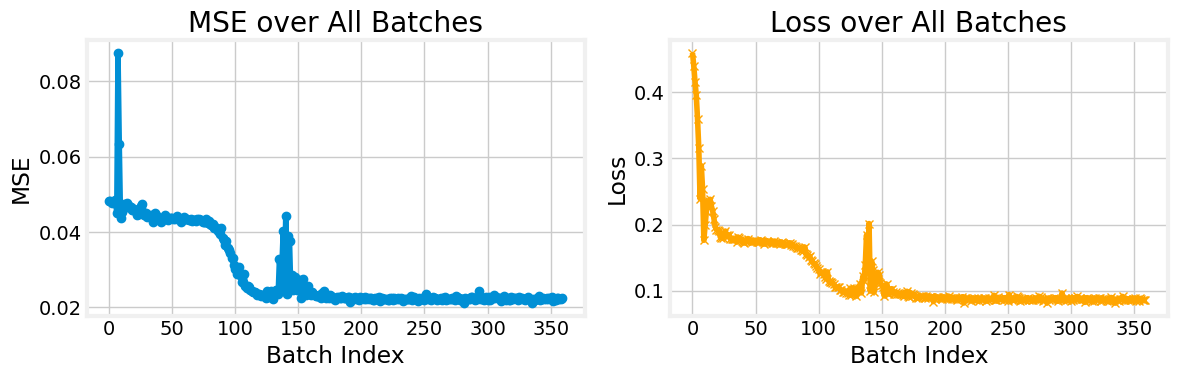


finished training MAMBA-123


In [20]:
%matplotlib inline
trainer(
    model_name='MAMBA',
    hidden_s=8,
    state_size=64,
    memory_size=64,
    epochs_length=60,
    seed=123,
    ckpt_dir='./mamba_ckpts/',
    ts_length=200,
    lr=0.01
)

Plot the results for offset prediction with the trained model. Also, plot the results for the two generalization experiments: two ISIs and Double-ISI.

Found 4 checkpoint files

Running evaluation for: offset phase
Configuration: seq_len=200, phase=(False, False), sample_idx=3
Number of checkpoint paths: 4
Using device: cuda
Generating data with seq_len=200, phase=(False, False)
Processing checkpoint: mamba_ckpts/MAMBA/MAMBA_0.01_8_64_200_ckpt_87996_20250706.pth
Extracted model info: MAMBA, lr=0.01, hidden_size=8, checkpoint_id=87996, date=20250706
Evaluating model MAMBA (hidden_size=8) from mamba_ckpts/MAMBA/MAMBA_0.01_8_64_200_ckpt_87996_20250706.pth
Successfully loaded checkpoint
ModelArgs(d_model=8, n_layer=1, vocab_size=2, d_state=64, expand=2, dt_rank=1, d_conv=4, pad_vocab_size_multiple=1, conv_bias=True, bias=False)
Successfully initialized model
Successfully loaded state dict
Successfully evaluated model, output shape: torch.Size([8, 200])
Processing checkpoint: mamba_ckpts/MAMBA/MAMBA_0.01_8_64_60_ckpt_123_20250706.pth
Extracted model info: MAMBA, lr=0.01, hidden_size=8, checkpoint_id=123, date=20250706
Evaluating model MAMB

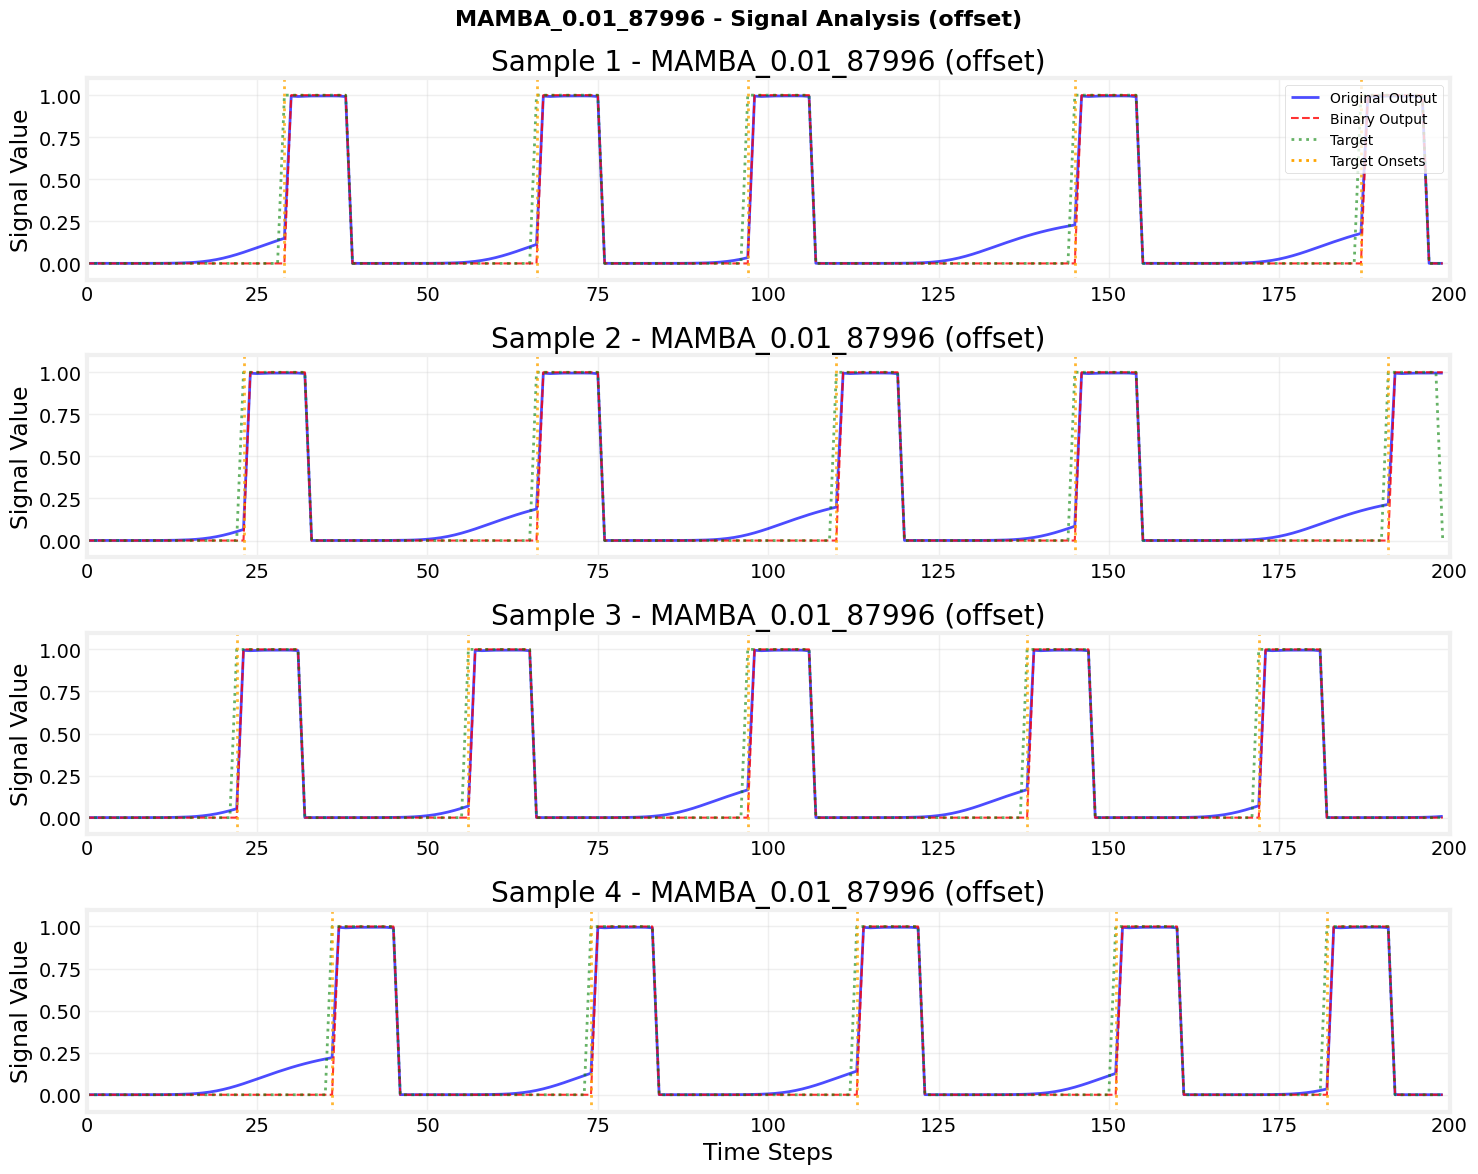

Saved plot for MAMBA_0.01_123


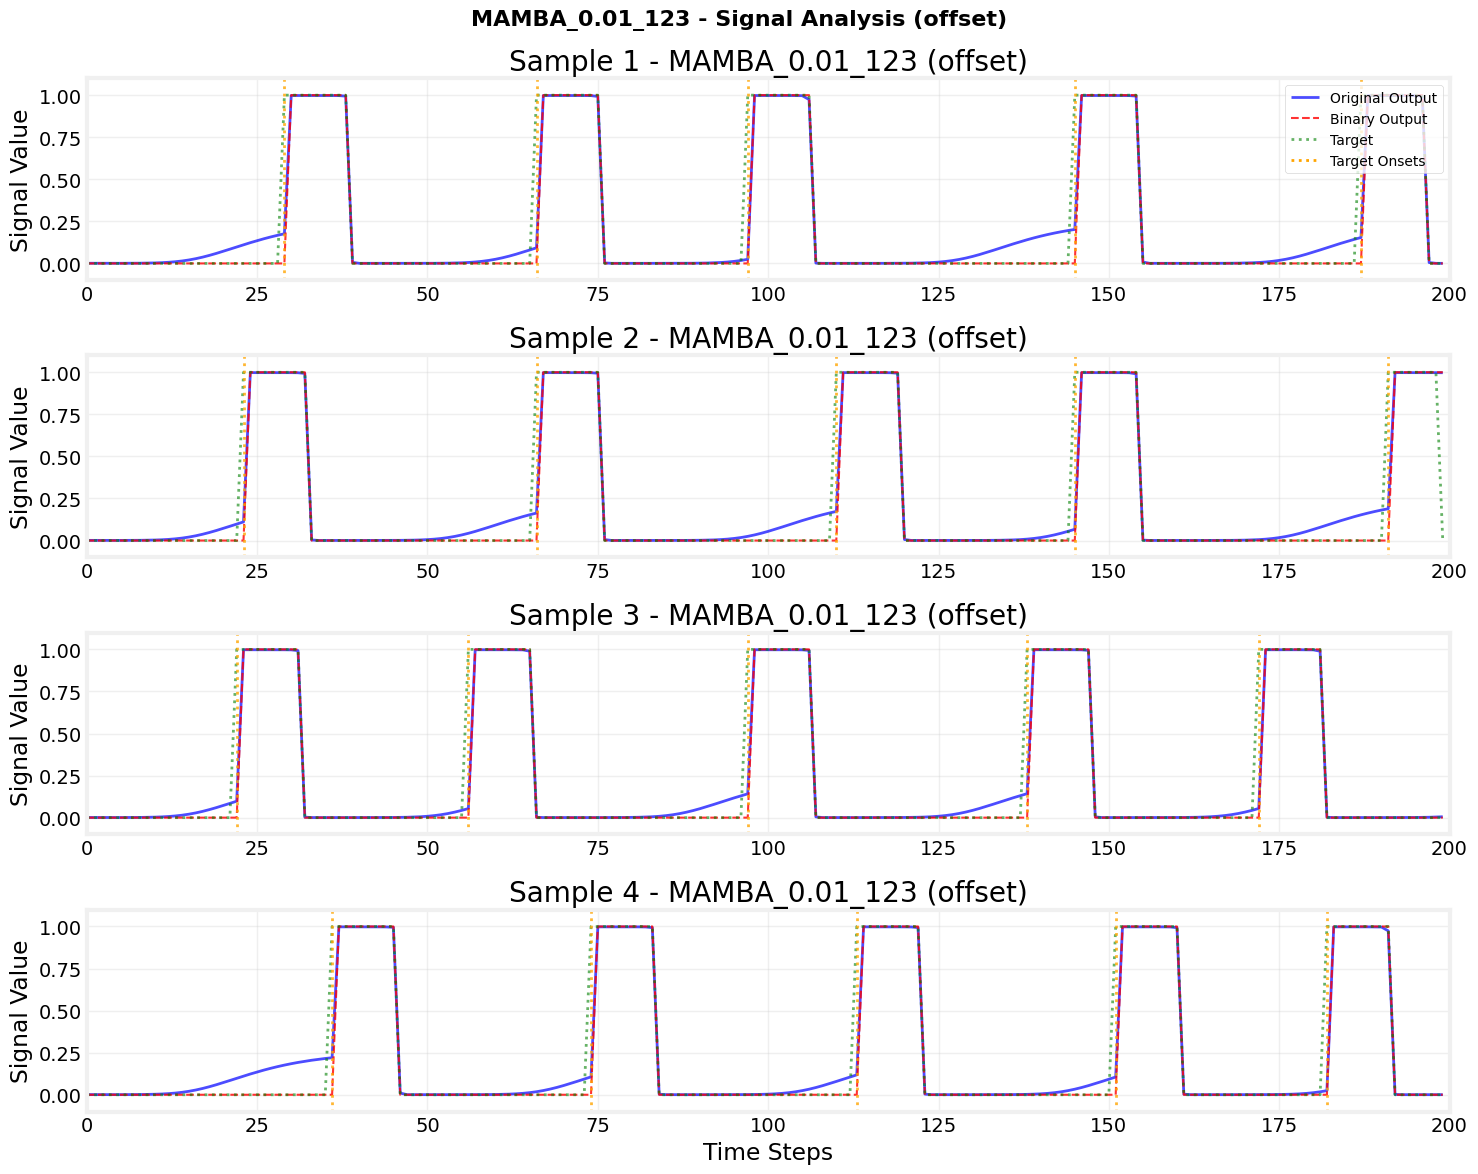

Saved comparison plot


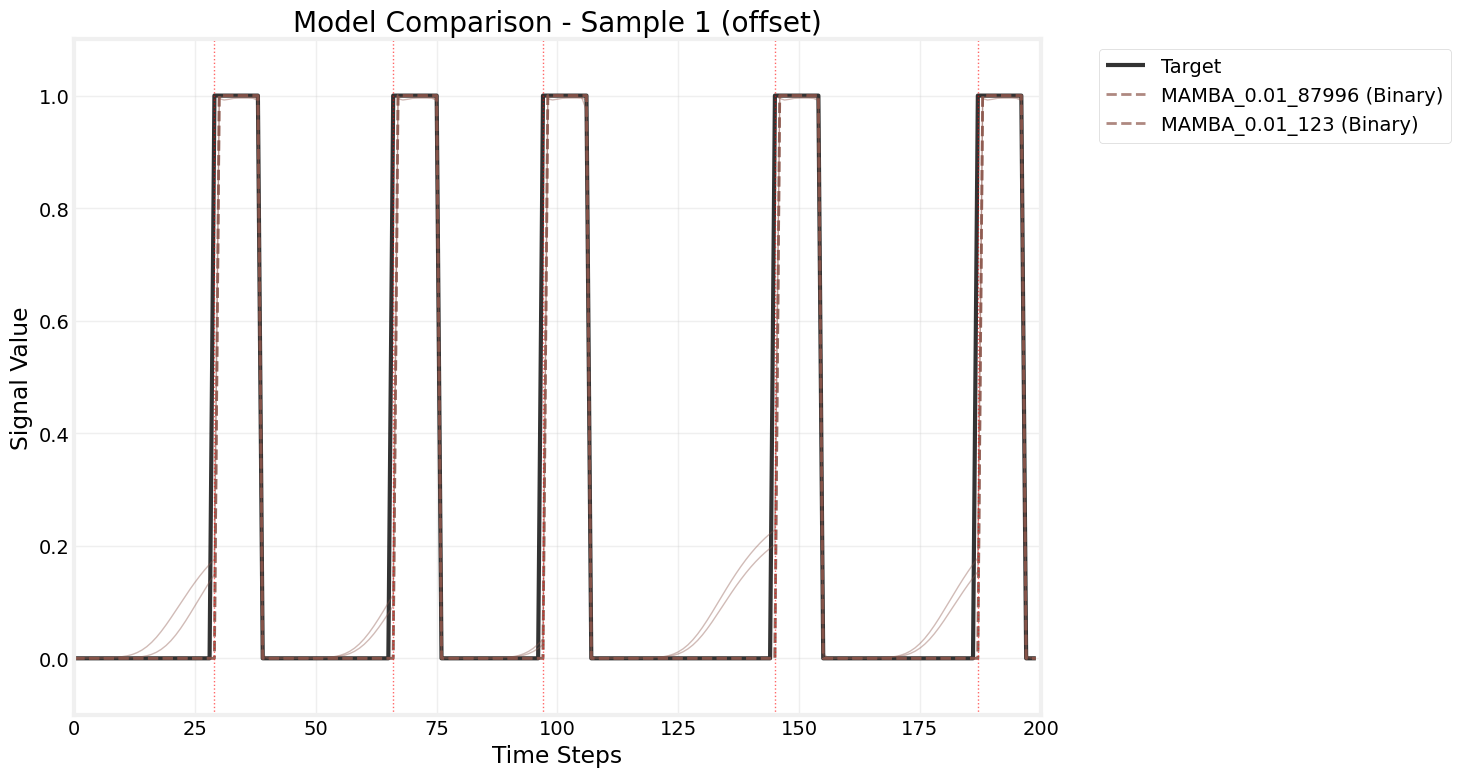

All done!
Processing experiment: conset
Generating plots...
Saved plot for MAMBA_0.01_87996


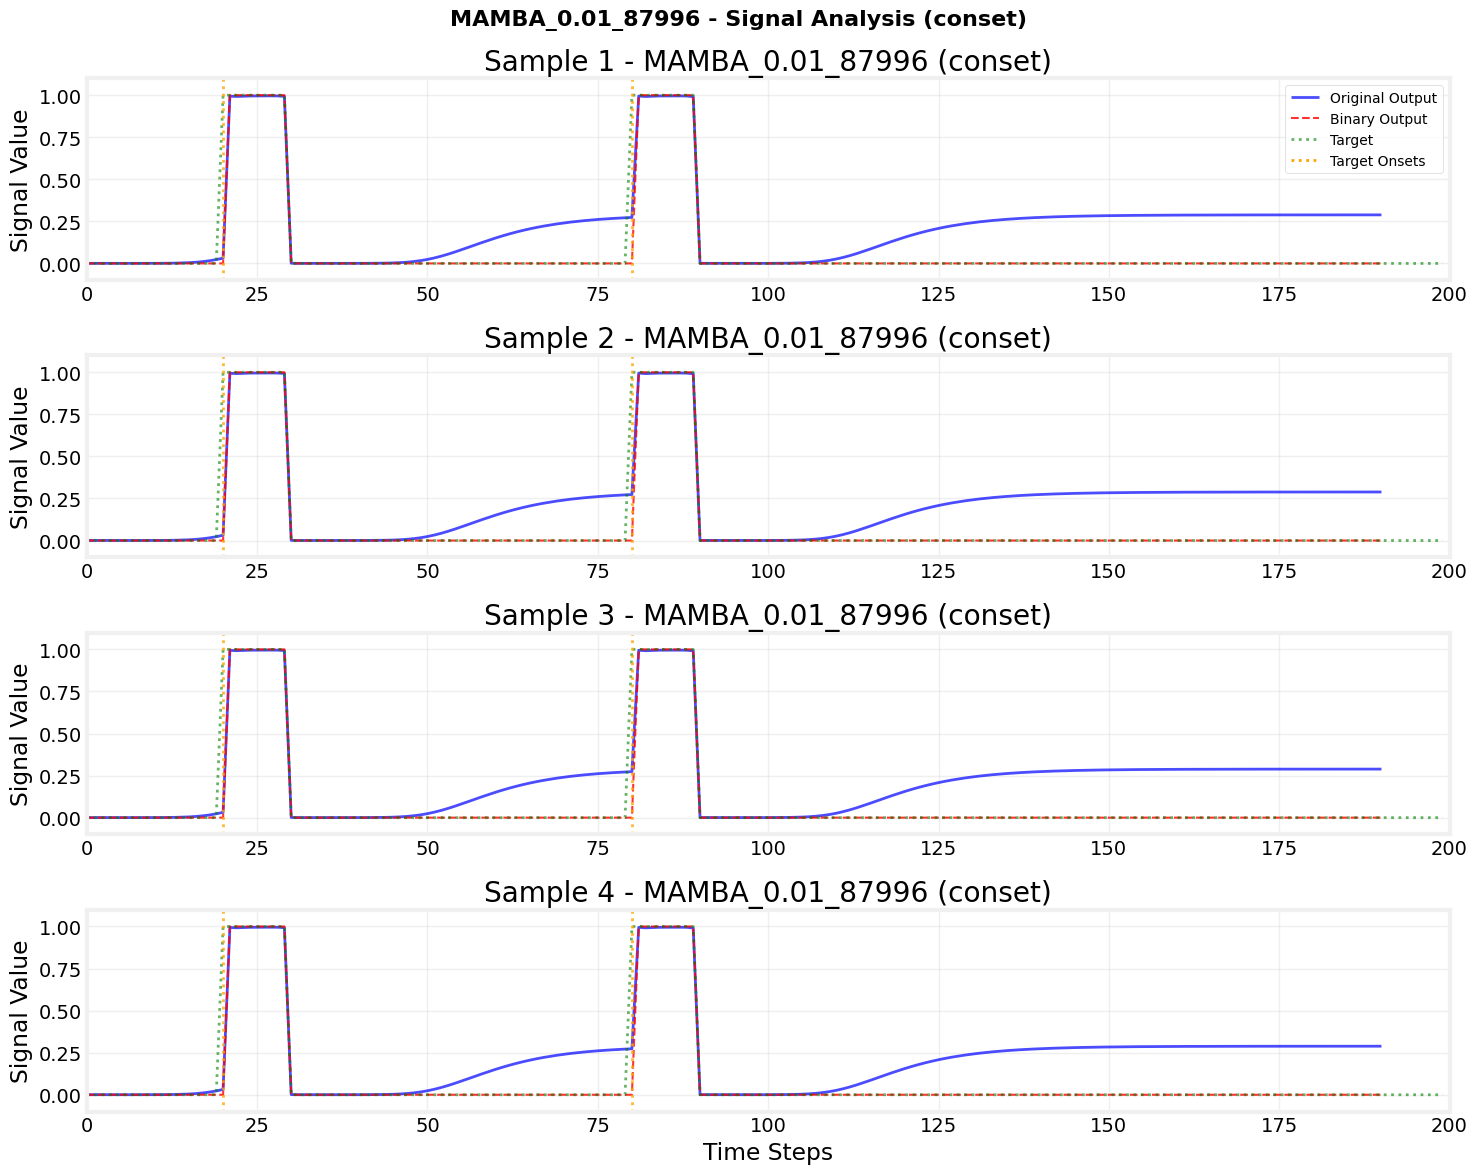

Saved plot for MAMBA_0.01_123


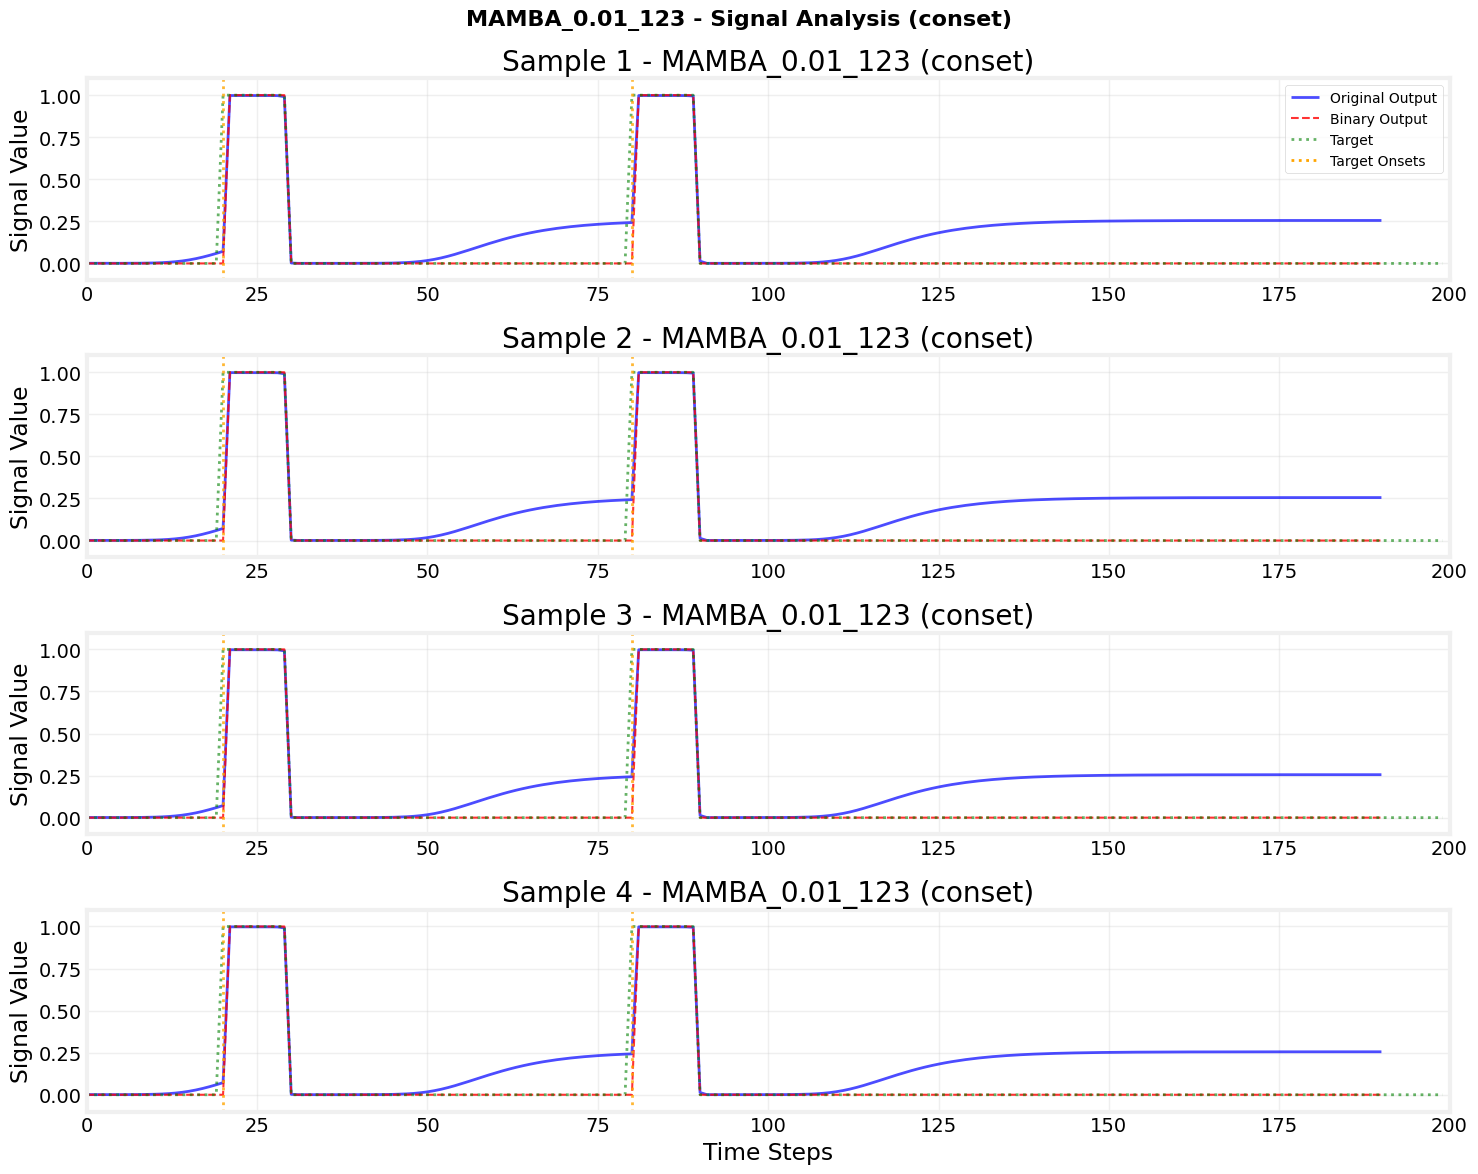

Saved comparison plot


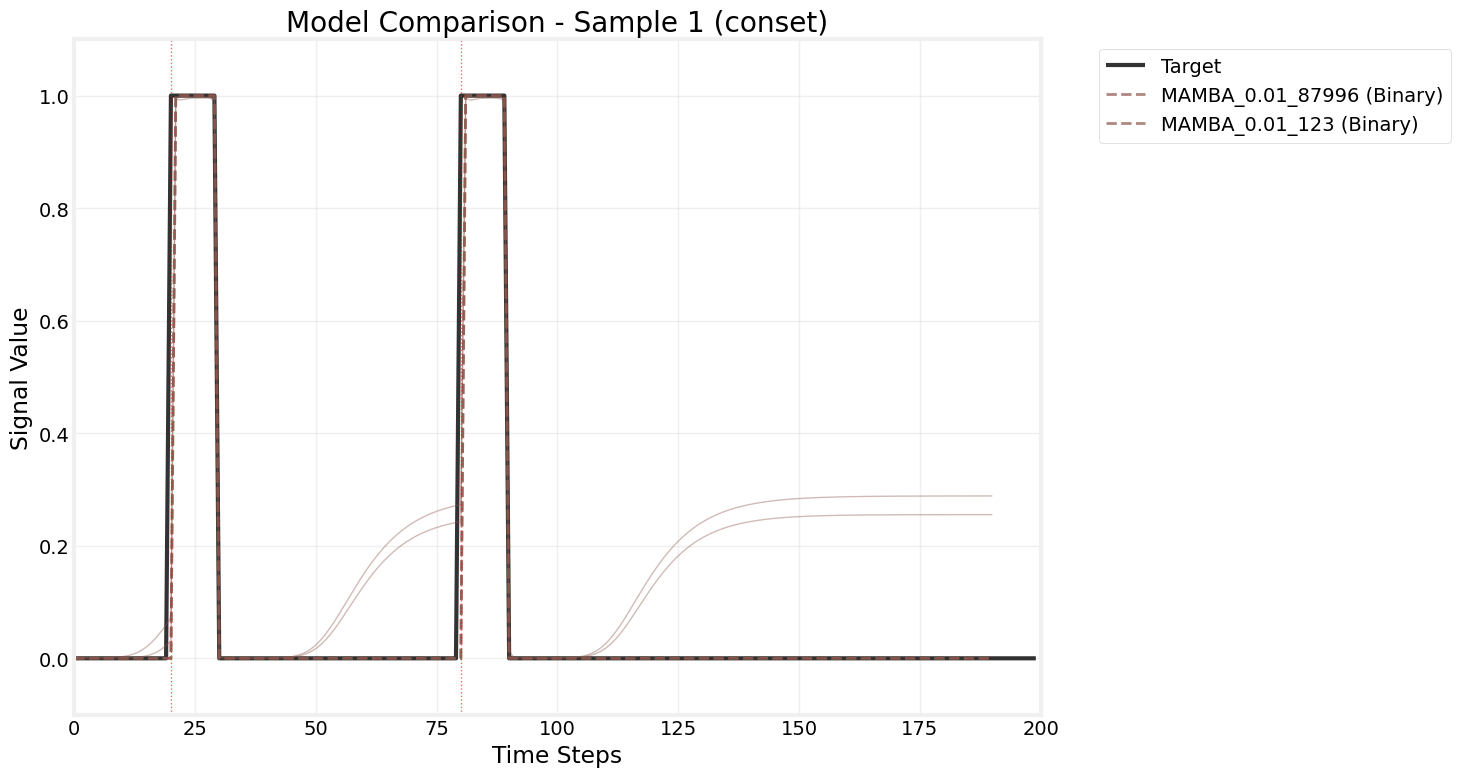

All done!
Processing experiment: double
Generating plots...
Saved plot for MAMBA_0.01_87996


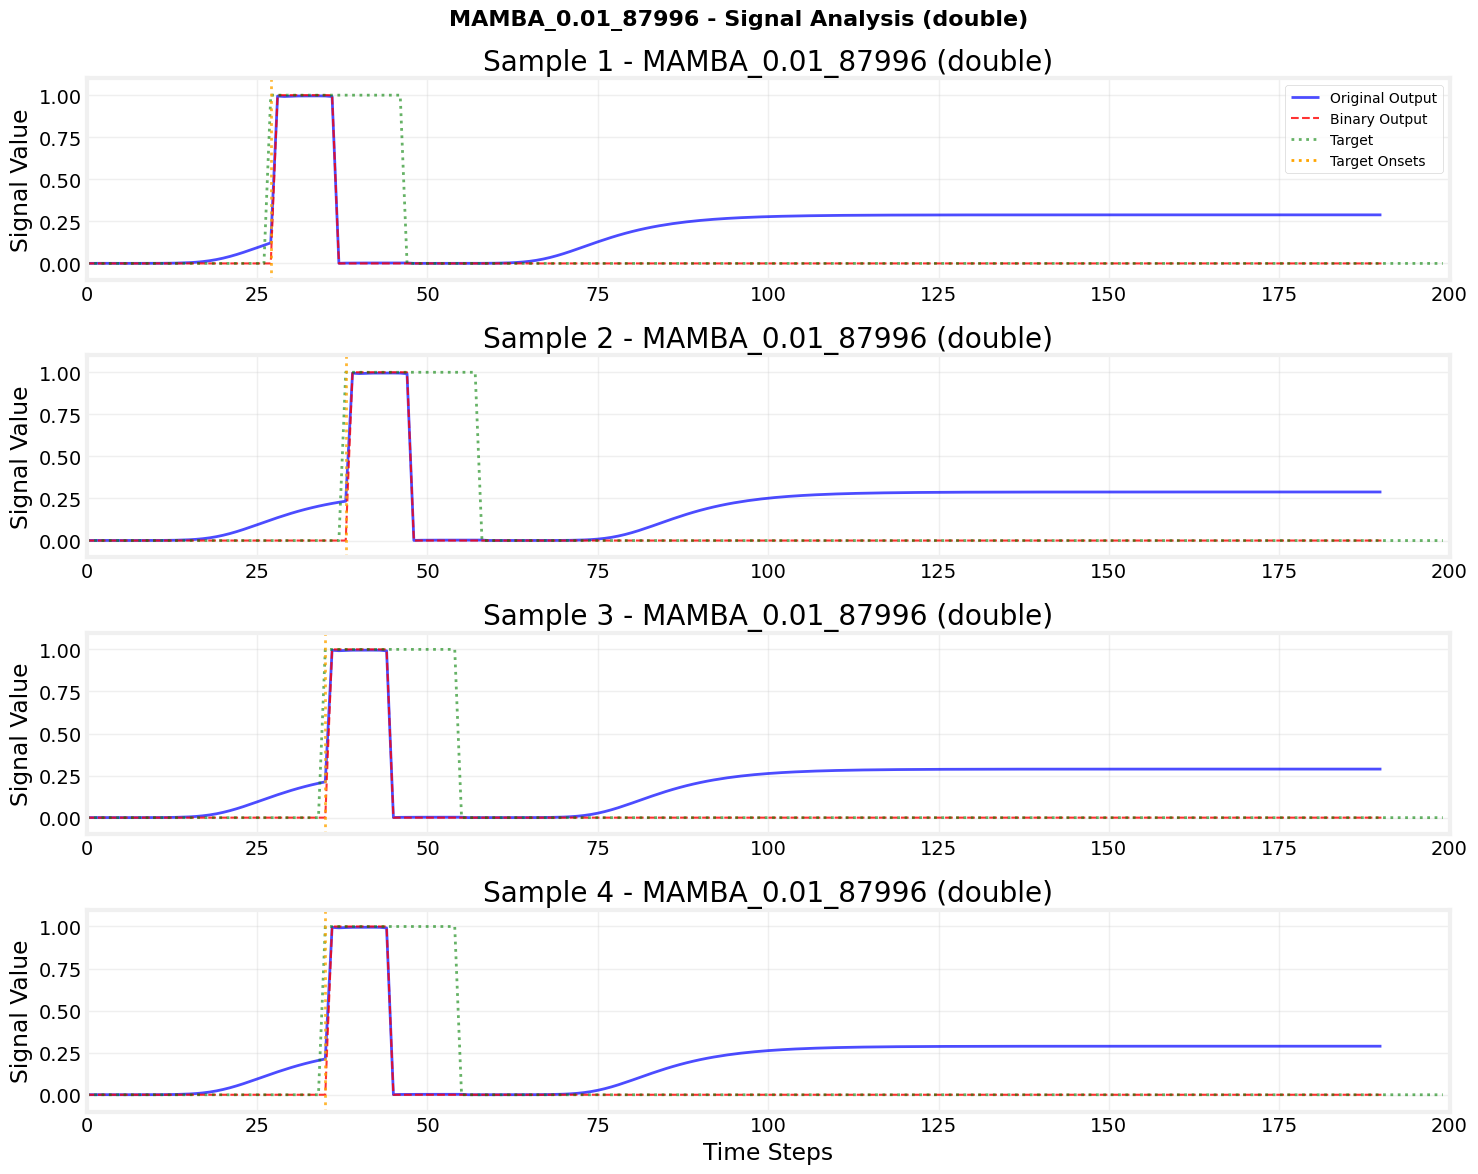

Saved plot for MAMBA_0.01_123


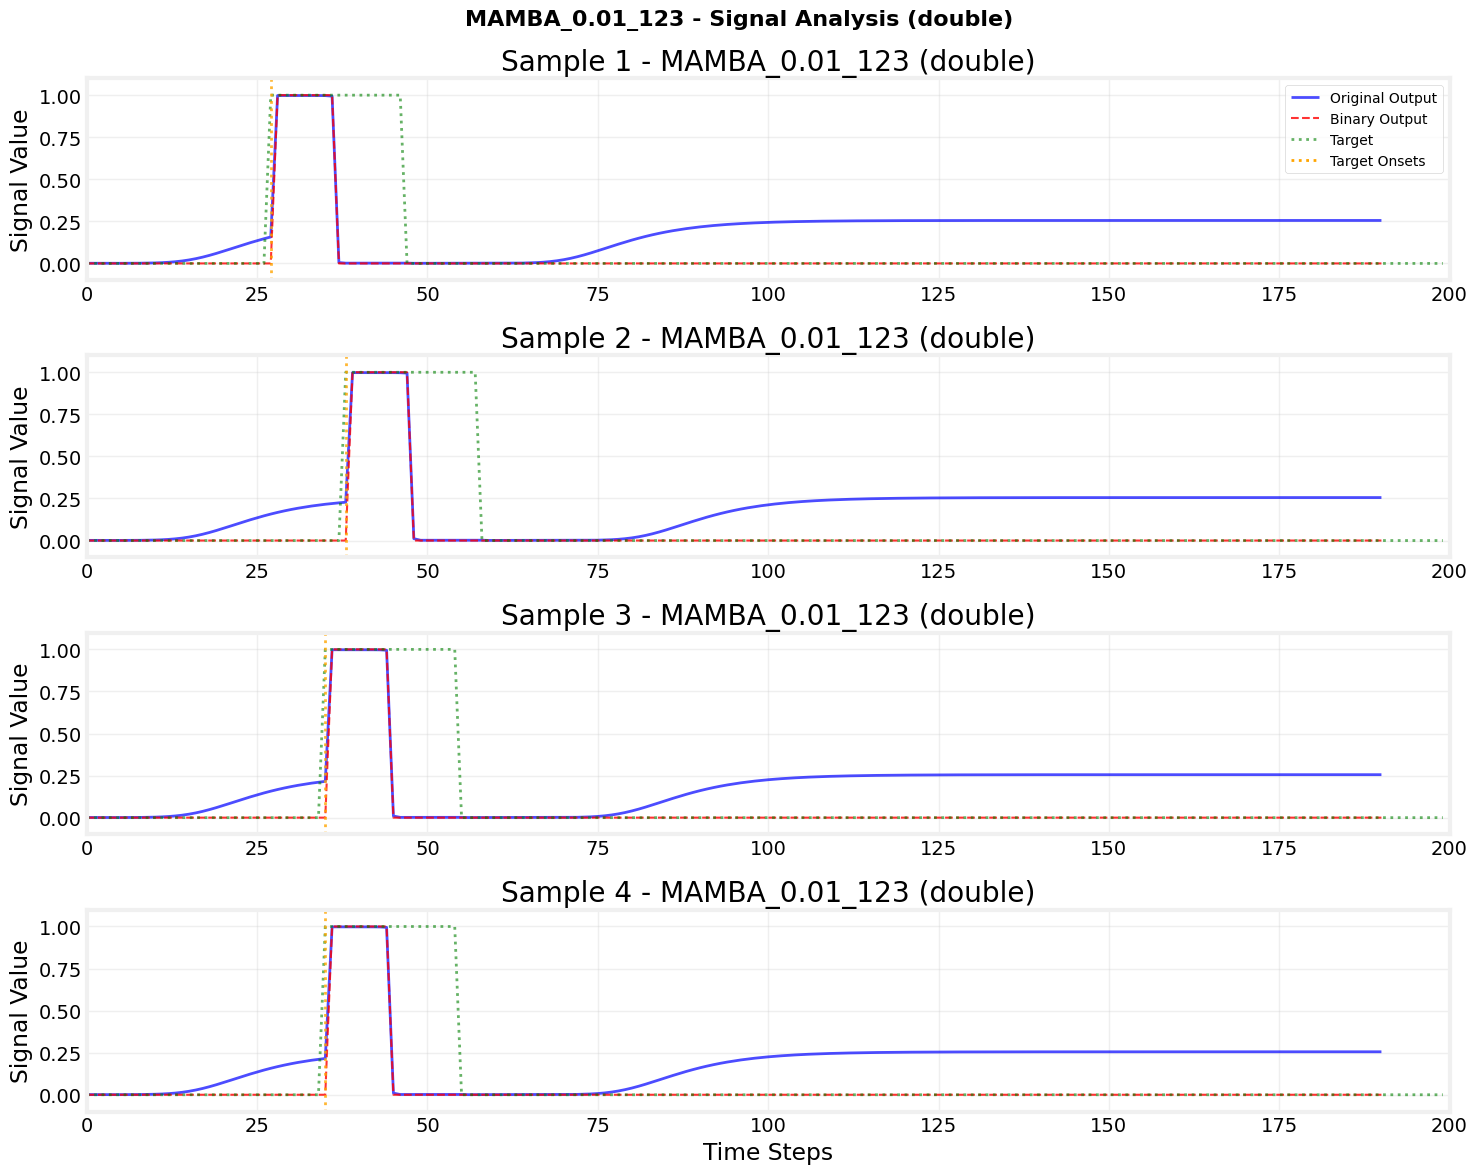

Saved comparison plot


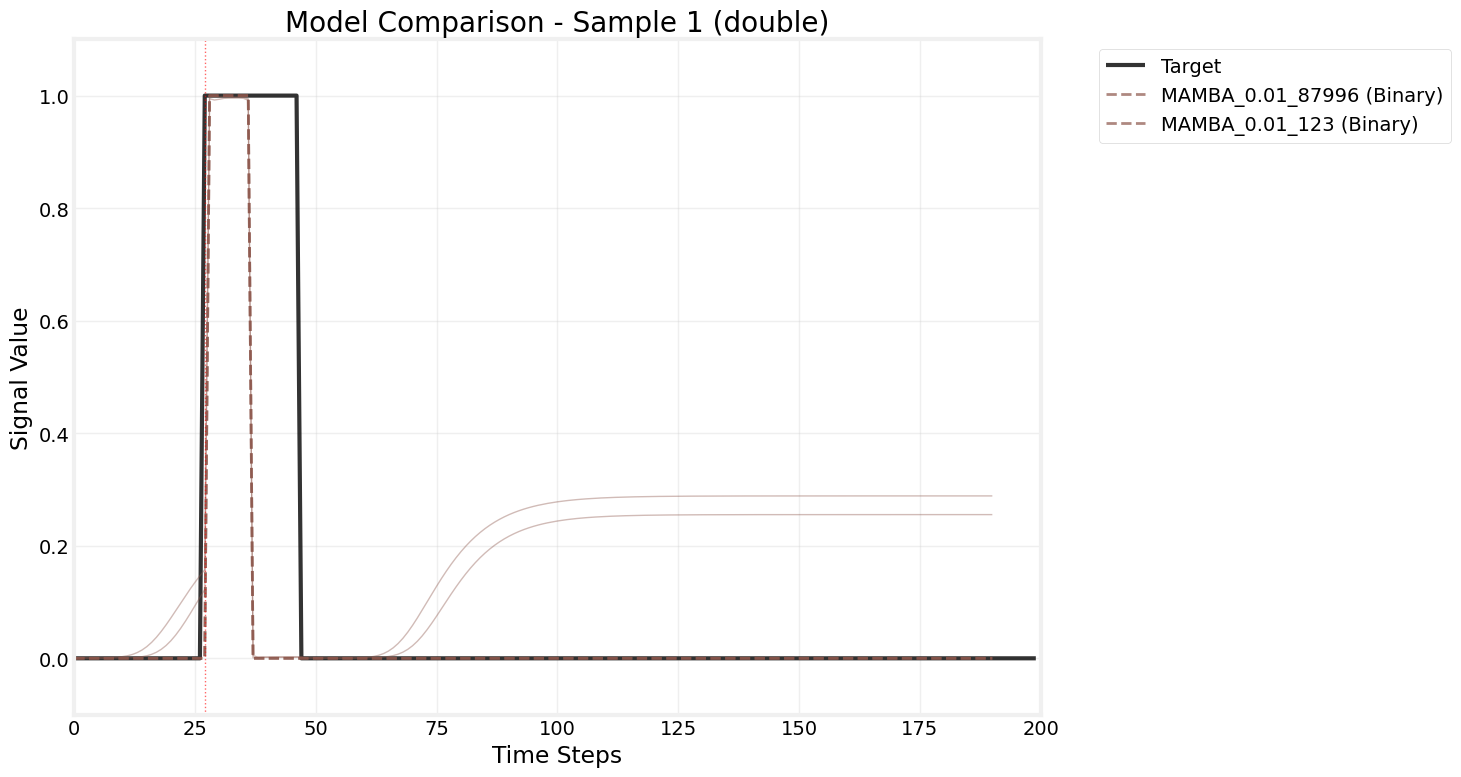

All done!


In [21]:
# Define your checkpoint base directory
ckpt_base = Path("./mamba_ckpts")

# Collect all .pth checkpoints recursively
checkpoint_paths = sorted([str(p) for p in ckpt_base.glob("**/*.pth")])
print(f"Found {len(checkpoint_paths)} checkpoint files")

# Define your experiments
phases = {
    "offset": '(False, False)',
    "consec": '(True, True)',
    "double": '(True, False)',
}

# Run evaluation for each phase
results = []
for name, phase in phases.items():
    print(f"\nRunning evaluation for: {name} phase")
    result = evaluate_custom_models(checkpoint_paths, seq_len=200, phase=phase)
    results.append(result)

# Plot results
for result in results:
    if result:
        print(f"Processing experiment: {result['type_phase']}")
        print("Generating plots...")
        figures = plot_results(result, save_plots=True)
        print("All done!")
    else:
        print("No results to plot - check your model paths and dependencies!")


### Train S4D model

0it [00:00, ?it/s]


Making a new set of Train, Test and Validation data.

Datasets created!

Making a new set of Train, Test and Validation data.

Datasets created!

Making a new set of Train, Test and Validation data.

Datasets created!
Optimizer group 0 | 7 tensors | weight_decay 0.01
Optimizer group 1 | 1 tensors | weight_decay 0.01
Optimizer group 2 | 4 tensors | weight_decay 0.0

training S4D-879965


Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s]

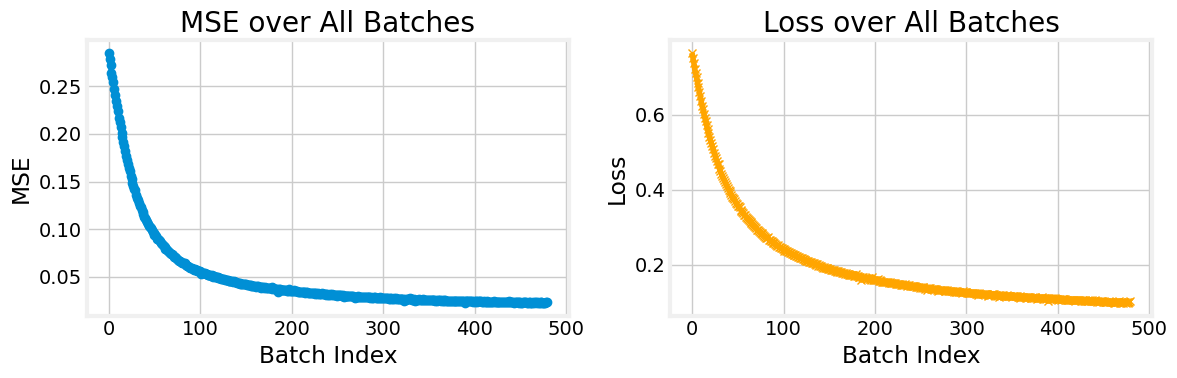


finished training S4D-879965


In [23]:
%matplotlib inline
trainer(
    model_name='S4D',
    hidden_s=8,
    state_size=64,
    memory_size=64,
    epochs_length=80,
    seed=879965,
    ckpt_dir='./s4d_ckpts/',
    ts_length=200,
    lr=0.001
)

Plot the results for offset prediction with the trained model. Also, plot the results for the two generalization experiments: two ISIs and Double-ISI.

Found 1 checkpoint files

Running evaluation for: offset phase
Configuration: seq_len=200, phase=(False, False), sample_idx=3
Number of checkpoint paths: 1
Using device: cuda
Generating data with seq_len=200, phase=(False, False)
Processing checkpoint: s4d_ckpts/S4D/S4D_0.001_8_64_80_ckpt_879965_20250706.pth
Extracted model info: S4D, lr=0.001, hidden_size=8, checkpoint_id=879965, date=20250706
Evaluating model S4D (hidden_size=8) from s4d_ckpts/S4D/S4D_0.001_8_64_80_ckpt_879965_20250706.pth
Successfully loaded checkpoint
Successfully initialized model
Successfully loaded state dict
Successfully evaluated model, output shape: torch.Size([8, 200])
Model: S4D_0.001_879965
sequence length: 200
Match ratio: 1.00
Threshold met: True
Sequences with matches: 8 out of 8
Total matching offsets: 37 out of 5



Running evaluation for: consec phase
Configuration: seq_len=200, phase=(True, True), sample_idx=3
Number of checkpoint paths: 1
Using device: cuda
Generating data with seq_len=200, phase=(

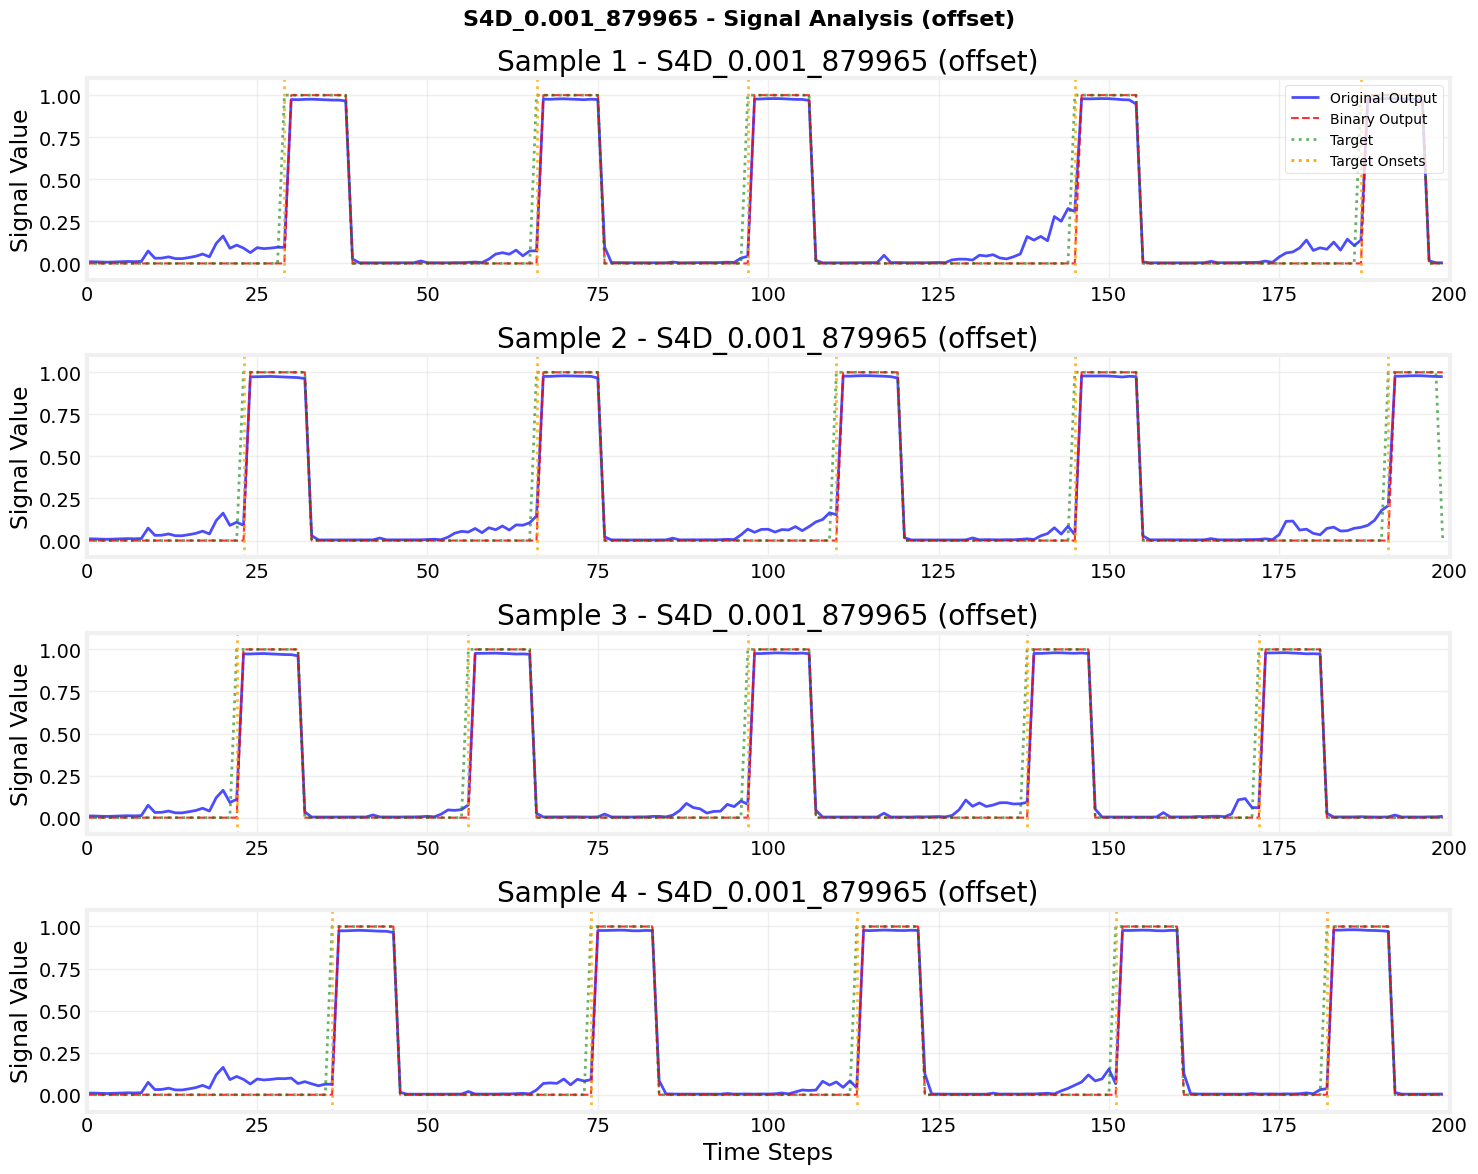

All done!
Processing experiment: conset
Generating plots...
Saved plot for S4D_0.001_879965


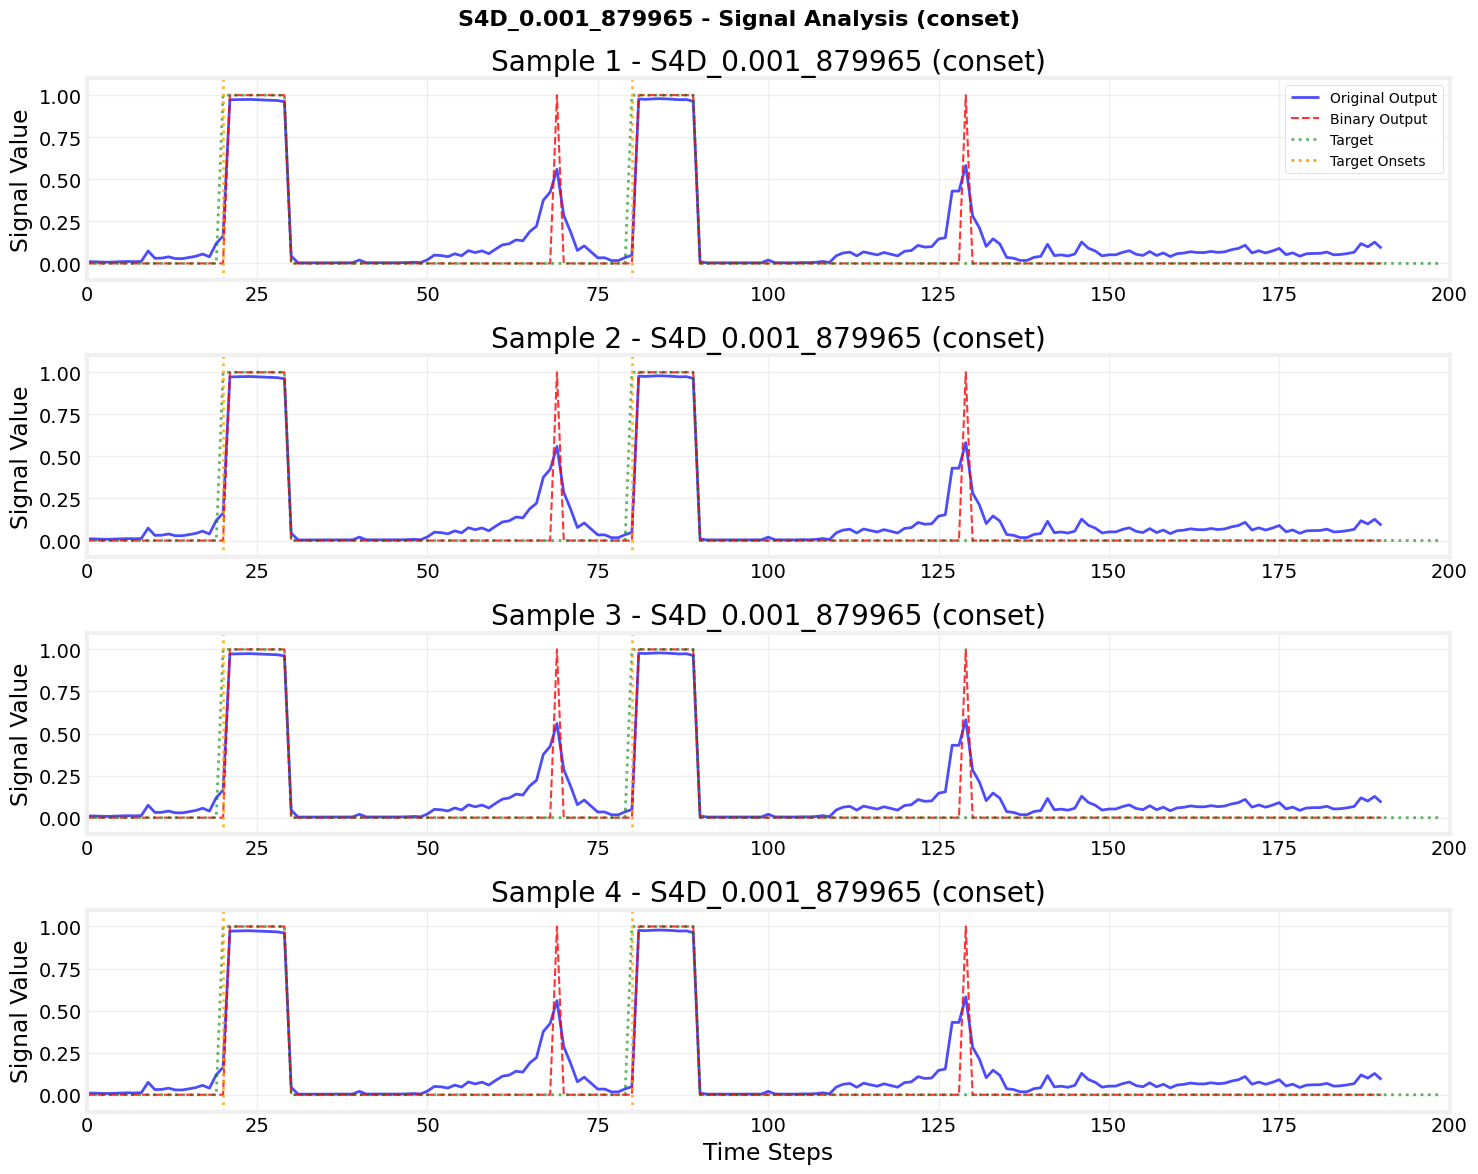

All done!
Processing experiment: double
Generating plots...
Saved plot for S4D_0.001_879965


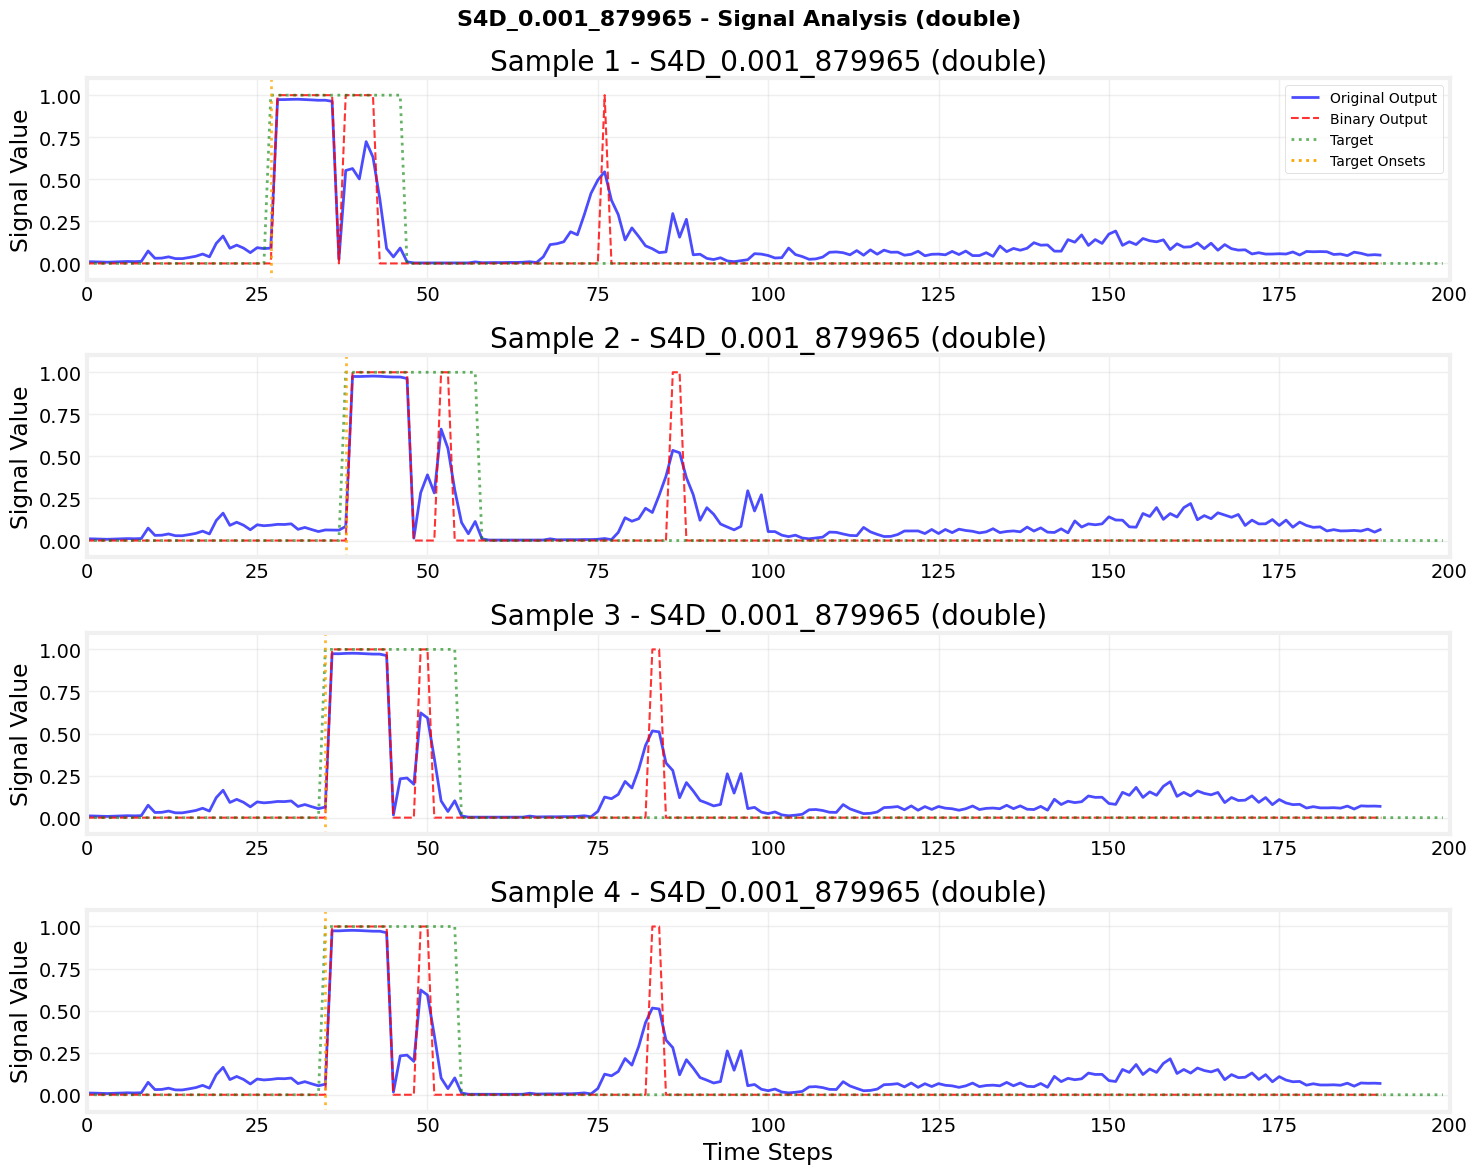

All done!


2

In [13]:
# Define your checkpoint base directory
ckpt_base = Path("./s4d_ckpts")

# Collect all .pth checkpoints recursively
checkpoint_paths = sorted([str(p) for p in ckpt_base.glob("**/*.pth")])
print(f"Found {len(checkpoint_paths)} checkpoint files")

# Define your experiments
phases = {
    "offset": '(False, False)',
    "consec": '(True, True)',
    "double": '(True, False)',
}

# Run evaluation for each phase
results = []
for name, phase in phases.items():
    print(f"\nRunning evaluation for: {name} phase")
    result = evaluate_custom_models(checkpoint_paths, seq_len=200, phase=phase)
    results.append(result)

# Plot results
for result in results:
    if result:
        print(f"Processing experiment: {result['type_phase']}")
        print("Generating plots...")
        figures = plot_results(result, save_plots=True)
        print("All done!")
    else:
        print("No results to plot - check your model paths and dependencies!")
2

 Plot results for both models


In [ ]:
from pathlib import Path

# Define checkpoint directories
mamba_ckpt_base = Path("./mamba_ckpts")
s4d_ckpt_base = Path("./s4d_ckpts")

# Collect all .pth checkpoints recursively
mamba_ckpts = sorted([str(p) for p in mamba_ckpt_base.glob("**/*.pth")])
s4d_ckpts = sorted([str(p) for p in s4d_ckpt_base.glob("**/*.pth")])
print(f"Found {len(mamba_ckpts)} MAMBA and {len(s4d_ckpts)} S4D checkpoint files")

# Define your experiments
phases = {
    "offset": '(False, False)',
    "consec": '(True, True)',
    "double": '(True, False)',
}

# Run evaluation for each phase
mamba_results = []
s4d_results = []

for name, phase in phases.items():
    print(f"\nEvaluating phase: {name}")

    print("Running MAMBA...")
    mamba_result = evaluate_custom_models(mamba_ckpts, seq_len=200, phase=phase)
    mamba_results.append(mamba_result)

    print("Running S4D...")
    s4d_result = evaluate_custom_models(s4d_ckpts, seq_len=200, phase=phase)
    s4d_results.append(s4d_result)

# Plot MAMBA vs S4D outputs together
print("\nPlotting MAMBA vs S4D outputs...")
plot_joint_outputs_from_two_runs(mamba_results, s4d_results, model_names=("MAMBA", "S4D"), sample_idx=3)


Extensive experiments: Training models on signal length 200 for 80 epochs each, and testing on lengths 200, 300, 400.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# CONFIG
models = ['S4D', 'MAMBA']
ckpt_dirs = {
    'MAMBA': Path("./mamba_ckpts"),
    'S4D': Path("./s4d_ckpts"),
}
epoch_lengths = [80]
seq_lengths = [200, 300, 400]  # 1x, 1.5x, 2x
phases = {
    "offset": '(False, False)',
    "consec": '(True, True)',
    "double": '(True, False)',
}

# STORAGE
all_results = []

# TRAIN + EVALUATE
for epochs in epoch_lengths:
    for model in models:
        if model == 'S4D': lr = 0.005
        else: lr = 0.01
        ckpt_dir = ckpt_dirs[model]

        # 1. TRAIN
        display(Markdown(f"# Training `{model}` for {epochs} epochs"))
        trainer(
            model_name=model,
            hidden_s=8,
            state_size=64,
            memory_size=64,
            epochs_length=epochs,
            seed=87996,
            ckpt_dir=str(ckpt_dir),
            ts_length=200,
            lr=lr
        )

        # 2. COLLECT CHECKPOINTS
        checkpoint_paths = sorted([str(p) for p in ckpt_dir.glob("**/*.pth")])
        display(Markdown(f"**Found {len(checkpoint_paths)} checkpoint(s) in `{ckpt_dir}`**"))

        # 3. EVALUATE
        for seq_len in seq_lengths:
            display(Markdown(f"## Evaluating `{model}` at sequence length {seq_len}"))
            for phase_name, phase in phases.items():
                display(Markdown(f"**Phase: {phase_name}**"))
                result = evaluate_custom_models(checkpoint_paths, seq_len=seq_len, phase=phase)
                if result:
                    result['meta'] = {
                        'model': model,
                        'epochs': epochs,
                        'seq_len': seq_len,
                        'phase': phase_name,
                        'ckpts': checkpoint_paths,
                    }
                    all_results.append(result)
                else:
                    print(f"[WARNING] No result for {model} | phase={phase_name} | seq_len={seq_len} | epochs={epochs}")

# 4. FINAL PLOTS
display(Markdown("# Final Plots for All Experiments"))

for result in all_results:
    meta = result['meta']
    title = f"{meta['model']} | {meta['phase']} | {meta['seq_len']} steps | {meta['epochs']} epochs"
    display(Markdown(f"### {title}"))
    figures = plot_results(result, save_plots=True)
    for fig in figures:
        plt.figure(fig.number)
        plt.show()


In [ ]:
from pathlib import Path
from IPython.display import display, Markdown

# Setup
phases = {
    "offset": '(False, False)',
    "consec": '(True, True)',
    "double": '(True, False)',
}
seq_lengths = [200, 300, 400]  # adjust as needed

# Define checkpoint directories
mamba_ckpt_base = Path("./mamba_ckpts")
s4d_ckpt_base = Path("./s4d_ckpts")

# Collect checkpoints
mamba_ckpts = sorted([str(p) for p in mamba_ckpt_base.glob("**/*.pth")])
s4d_ckpts = sorted([str(p) for p in s4d_ckpt_base.glob("**/*.pth")])
print(f"Found {len(mamba_ckpts)} MAMBA and {len(s4d_ckpts)} S4D checkpoint files")

# Run comparison
for seq_len in seq_lengths:
    for phase_name, phase in phases.items():
        display(Markdown(f"## Comparing MAMBA vs S4D | Phase: `{phase_name}` | Sequence Length: {seq_len}"))

        try:
            mamba_result = evaluate_custom_models(mamba_ckpts, seq_len=seq_len, phase=phase)
            s4d_result = evaluate_custom_models(s4d_ckpts, seq_len=seq_len, phase=phase)

            # Check both are dicts (i.e., valid result objects)
            if isinstance(mamba_result, dict) and isinstance(s4d_result, dict):
                plot_joint_outputs_from_two_runs(
                    mamba_result, s4d_result,
                    model_names=("MAMBA", "S4D"),
                    sample_idx=3
                )
            else:
                print(f"[SKIPPED] One of the results is invalid for phase={phase_name}, seq_len={seq_len}")
                if not isinstance(mamba_result, dict):
                    print("  [MAMBA] Invalid result:", type(mamba_result), mamba_result)
                if not isinstance(s4d_result, dict):
                    print("  [S4D] Invalid result:", type(s4d_result), s4d_result)

        except Exception as e:
            print(f"[ERROR] Exception for phase={phase_name}, seq_len={seq_len}: {e}")
